# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import divexplorer 
import pandas as pd
pd.set_option('max_colwidth', None)
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from utils_analysis import filter_itemset_df_by_attributes, slice_by_itemset, \
    plot_true_pred, plotComparisonShapleyValues, plotMultipleSV, plotShapleyValue

In [3]:
## Define the minimum support threshold for data subgroups
min_sup = 0.03

# Util Functions

In [4]:
## Function for computing the percentage of error for the problematic speaker in a given slice
def percentage_problematic_speaker(df_sel, max_perc = 0.25, column = "prediction", groupby = "speakerId", problematic_speaker = "NgQEvO2x7Vh3xy2xz"):
    """ Check if source of error is for more that max_perc of the problematic speaker
        df_sel (pd.DataFrame) : dataset
        max_perc (float): max percentage.
    
        Returns bool, percentage_error: True if percentage of error of the problematic speaker in the slice is greater than threshold
    """
    df_sel_sk = df_sel.copy()
    if "speakerId" not in df_sel_sk.columns:
        df_sel_sk['speakerId'] = df_sel_sk.index.map(lambda x: x.split("/")[3])
    
    tot_prediction_count = dict(df_sel_sk[column].value_counts())
    if 0 not in tot_prediction_count:
        return False, 0
    tot_error_slice = tot_prediction_count[0]
    df_sel_i = df_sel_sk.loc[df_sel_sk[groupby] == problematic_speaker]
    if df_sel_i.shape[0]==0:
        return False, 0
    prediction_counts = dict(df_sel_i[column].value_counts())
    if 0 not in prediction_counts:
        return False, 0
    percentage_error = prediction_counts[0]/tot_error_slice
    return percentage_error > max_perc, percentage_error


In [5]:
## Function for sorting data cohorts
def sortItemset(x, abbreviations={}):
    x = list(x)
    x.sort()
    x = ", ".join(x)
    for k, v in abbreviations.items():
        x = x.replace(k, v)
    return x

In [6]:
def attributes_in_itemset(itemset, attributes, alls = True):
    """ Check if attributes are in the itemset (all or at least one)
    
    Args:
        itemset (frozenset): the itemset
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        
    """
    # Avoid returning the empty itemset (i.e., info of entire dataset)
    if itemset == frozenset() and attributes:
        return False
    
    for item in itemset:
        # Get the attribute
        attr_i = item.split("=")[0]
        
        #If True, check if ALL attributes of the itemset are the input attributes.
        if alls:
            # Check if the attribute is present. If not, the itemset is not admitted
            if attr_i not in attributes:
                return False
        else:
            # Check if least one attribute. If yes, return True
            if attr_i in attributes:
                return True
    if alls:
        # All attributes of the itemset are indeed admitted
        return True
    else:
        # Otherwise, it means that we find None
        return False
    
def filter_itemset_df_by_attributes(df: pd.DataFrame, attributes: list, alls = True, itemset_col_name: str = "itemsets") -> pd.DataFrame:
    """Get the set of itemsets that have the attributes in the input list (all or at least one)
    
    Args:
        df (pd.DataFrame): the input itemsets (with their info). 
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        itemset_col_name (str) : the name of the itemset column, "itemsets" as default
        
    Returns:
        pd.DataFrame: the set of itemsets (with their info)
    """

    return df.loc[df[itemset_col_name].apply(lambda x: attributes_in_itemset(x, attributes, alls = alls))]

In [7]:
## Function for substituting gender of a given itemset
substitute_gender = lambda x : "gender=male" if "gender=female" in x else ("gender=female" if "gender=male" in x else x)

In [8]:
## Define abbreviations for plot and visualization
from divexplorer.FP_Divergence import abbreviateDict
abbreviations = {'Self-reported fluency level=native': 'fluency=native', \
                  'total_silence':'tot_silence', 'location': 'loc', \
                  'Current language used for work/school=English (United States)': 'lang=EN_US', \
                  'ageRange': 'age', \
                  'speakerId' : 'spkID', \
                  'First Language spoken=English (United States)':  'lang=EN_US', \
                  'trimmed': 'trim', \
                  'total_': 'tot_', \
                  'speed_rate_word':'speakRate', \
                  'speed_rate_char':'speakCharRate', \
                  'change language': 'change lang', \
                  'duration': 'dur'}

abbreviations_shorter = abbreviations.copy()

In [9]:
n = 3  # Number of subgroups to visualize
K = 15  # Global Shapley values to visualize

# Define targets

In [10]:
## Target for DivExplorer: 
# 'prediction' is 1 if predicted_intet == original_intent, 0 otherwise
target_col = 'prediction' 
target_metric = 'd_posr'
target_div = 'd_accuracy'
t_value_col = 't_value_tp_fn'

In [11]:
## Columns for visualization
show_cols = ['support', 'itemsets', '#errors', '#corrects', 'accuracy', \
                'd_accuracy', 't_value', 'support_count', 'length']
remapped_cols = {'tn': '#errors', 'tp': '#corrects', 'posr': 'accuracy', \
                target_metric: target_div, 't_value_tp_fn': 't_value'}

In [12]:
## Columns of the df file that we are going to analyze 
demo_cols = ['Self-reported fluency level ', 'First Language spoken',
       'Current language used for work/school', 'gender', 'ageRange']

slot_cols = ['action', 'object', 'location']

signal_cols = ['total_silence', 'total_duration', 'trimmed_duration', 
       'n_words', 'speed_rate_word', 'speed_rate_word_trimmed'] 

input_cols = demo_cols + slot_cols + signal_cols 

# Retrieve Data and Compute Divergence

In [13]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [14]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", \
    "hubert-large", "wav2vec2-large-xlsr-53", "wav2vec2-xlsr-300m"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "FSC", f"FSC_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0 )
    df[target_col] = df[target_col]

    ## Add SpeakerID information if it is present in the df
    if "speakerId" in input_cols:
        df['speakerId'] = df.index.map(lambda x: x.split("/")[2])

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
        
    df_discretized.loc[df_discretized["location"]=="none_location", "location"] = "none"
    df_discretized.loc[df_discretized["object"]=="none_object", "object"] = "none"
    
    ## Create dict of Divergence df
    df_dict[config] = df_discretized
    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['accuracy'] = round(FP_fm['accuracy'], 5)
    FP_fm['d_accuracy'] = round(FP_fm['d_accuracy'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base


wav2vec2-large
hubert-base
hubert-large
wav2vec2-large-xlsr-53
wav2vec2-xlsr-300m


In [15]:
## Compute the accuracy of the models
for config in configs:
    prediction = df_dict[config]['prediction'].sum()/len(df_dict[config])
    print(f"Accuracy of {config}:", round(100*prediction,3))
    print("----------")

Accuracy of wav2vec2-base: 91.722
----------
Accuracy of wav2vec2-large: 93.172
----------
Accuracy of hubert-base: 98.418
----------
Accuracy of hubert-large: 98.497
----------
Accuracy of wav2vec2-large-xlsr-53: 90.079
----------
Accuracy of wav2vec2-xlsr-300m: 98.338
----------


In [16]:
W2V2_BASE_ACC = 91.722
W2V2_LARGE_ACC = 93.172
HUBERT_BASE_ACC = 98.418
HUBERT_LARGE_ACC = 98.497
XLSR_53_ACC = 90.079
XLSR_128_ACC = 98.338

In [17]:
## Check the accuracy of the models, divided by gender
for config in configs:
    print(config)
    print(filter_itemset_df_by_attributes(FP_fm_dict[config],['gender'], alls = True)\
        [['itemsets', 'accuracy', 'd_accuracy']]\
        .sort_values('d_accuracy', ascending = False))
    print("----------------")

wav2vec2-base
           itemsets  accuracy  d_accuracy
31  (gender=female)   0.92510     0.00789
35    (gender=male)   0.90864    -0.00858
----------------
wav2vec2-large
           itemsets  accuracy  d_accuracy
31  (gender=female)   0.95395     0.02223
35    (gender=male)   0.90754    -0.02418
----------------
hubert-base
           itemsets  accuracy  d_accuracy
31  (gender=female)   0.98735     0.00317
35    (gender=male)   0.98074    -0.00344
----------------
hubert-large
           itemsets  accuracy  d_accuracy
35    (gender=male)   0.98514     0.00017
31  (gender=female)   0.98482    -0.00015
----------------
wav2vec2-large-xlsr-53
           itemsets  accuracy  d_accuracy
33    (gender=male)   0.90639     0.00560
25  (gender=female)   0.89564    -0.00515
----------------
wav2vec2-xlsr-300m
           itemsets  accuracy  d_accuracy
25  (gender=female)   0.98480     0.00143
33    (gender=male)   0.98183    -0.00155
----------------


In [18]:
## Test Samples
config = 'wav2vec2-base'
print("Test Samples: ", len(df_dict[config]))
print("Subgroup Explored: ", len(FP_fm_dict[config]))

Test Samples:  3793
Subgroup Explored:  47736


In [19]:
## Compute time for the DivExplorer algorithm
import time
from tqdm import tqdm

overall_time = []

for i in tqdm(range(10)):

    ## Read csv file
    config = "wav2vec2-base"
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "FSC", f"FSC_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0 )
    df[target_col] = df[target_col]

    ## Add SpeakerID information if it is present in the df
    if "speakerId" in input_cols:
        df['speakerId'] = df.index.map(lambda x: x.split("/")[2])

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
        
    df_discretized.loc[df_discretized["location"]=="none_location", "location"] = "none"
    df_discretized.loc[df_discretized["object"]=="none_object", "object"] = "none"
    
    ## Compute time
    start_time = time.time()
    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
    # print("--- %s seconds ---" % (time.time() - start_time))
    overall_time.append(time.time() - start_time)

print("Average time: ", np.mean(overall_time))
print("Worst time: ", np.max(overall_time))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Average time:  1.4214525461196899
Worst time:  1.5990760326385498


# Divergence Wav2Vec2-Base

In [20]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

In [21]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  \
44217  age=22-40, gender=male, loc=none, speakRate=high, tot_silence=high   
32246            age=22-40, gender=male, speakRate=high, tot_silence=high   
39743  gender=male, loc=none, n_words=low, tot_silence=high, trim_dur=low   

       support  accuracy  d_accuracy  t_value  
44217     0.03    60.504     -31.217     7.05  
32246     0.04    62.857     -28.864     7.13  
39743     0.03    64.000     -27.722     6.54

Problematic Speaker
0 97.87
1 98.08
2 84.44


In [22]:
## Retrieve Most Positively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  support  \
27435     age=22-40, loc=washroom, speakRate=low, trim_dur=high     0.04   
30478   gender=male, n_words=high, object=heat, tot_silence=low     0.04   
30952  gender=male, object=heat, tot_silence=low, trim_dur=high     0.04   

       accuracy  d_accuracy  t_value  
27435     100.0       8.278     9.74  
30478     100.0       8.278     9.35  
30952     100.0       8.278     9.30

Problematic Speaker
0 0
1 0
2 0


Accuracy:  60.504
Δ_Acc:  -31.218
Support:  0.031


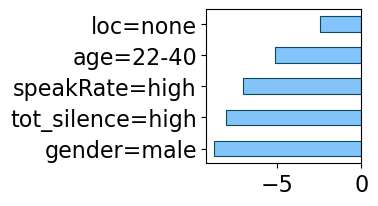

Accuracy:  91.071
Δ_Acc:  -0.651
Support:  0.044


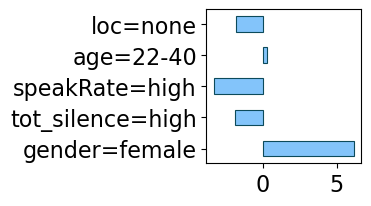

In [23]:
import warnings
warnings.filterwarnings('ignore')

## Subgroup: {'age=22-40', 'gender=male', 'loc=none', 'speakRate=high', 'tot_silence=high'}
negative_itemset = frozenset({'ageRange=22-40', 'gender=male', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", round(acc,3))
print("Δ_Acc: ", round(acc - W2V2_BASE_ACC,3))
print("Support: ", round(pr[pr['itemsets'] == negative_itemset].iloc[0]['support'],3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/w2v2b_most_negative_1.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=True)

## Subgroup: {'age=22-40', 'gender=female', 'loc=none', 'speakRate=high', 'tot_silence=high'}
positive_itemset = frozenset({'ageRange=22-40', 'gender=female', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", round(acc,3))
print("Δ_Acc: ", round(acc - W2V2_BASE_ACC,3))
print("Support: ", round(pr[pr['itemsets'] == positive_itemset].iloc[0]['support'],3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}

# reorder itemset_shap so as to match the order of the previous plot
itemset_shap = {frozenset({'gender=female'}): itemset_shap[frozenset({'gender=female'})], \
                frozenset({'tot_silence=high'}): itemset_shap[frozenset({'total_silence=high'})], \
                frozenset({'speakRate=high'}): itemset_shap[frozenset({'speed_rate_word=high'})], \
                frozenset({'age=22-40'}): itemset_shap[frozenset({'ageRange=22-40'})], \
                frozenset({'loc=none'}): itemset_shap[frozenset({'location=none'})],
                }

name_fig = f"plot_results/FSC/w2v2b_most_negative_1_females.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=True, sortedF=False)

Accuracy:  100.0
Δ_Acc:  8.278
Support:  0.04


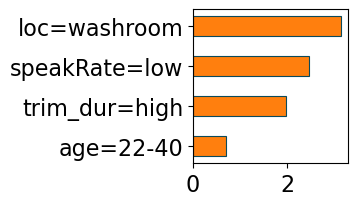

In [24]:
import warnings
warnings.filterwarnings('ignore')

## Subgroup: {'ageRange=22-40, location=washroom, speed_rate_word=low, trim_dur=high'}
positive_itemset = frozenset({'ageRange=22-40', 'location=washroom', 'speed_rate_word=low', 'trimmed_duration=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", round(acc,3))
print("Δ_Acc: ", round(acc - W2V2_BASE_ACC,3))
print("Support: ", round(pr[pr['itemsets'] == positive_itemset].iloc[0]['support'],3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/w2v2b_most_positive.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=False,
                nameFig=name_fig, saveFig=True)

Individual Divergence


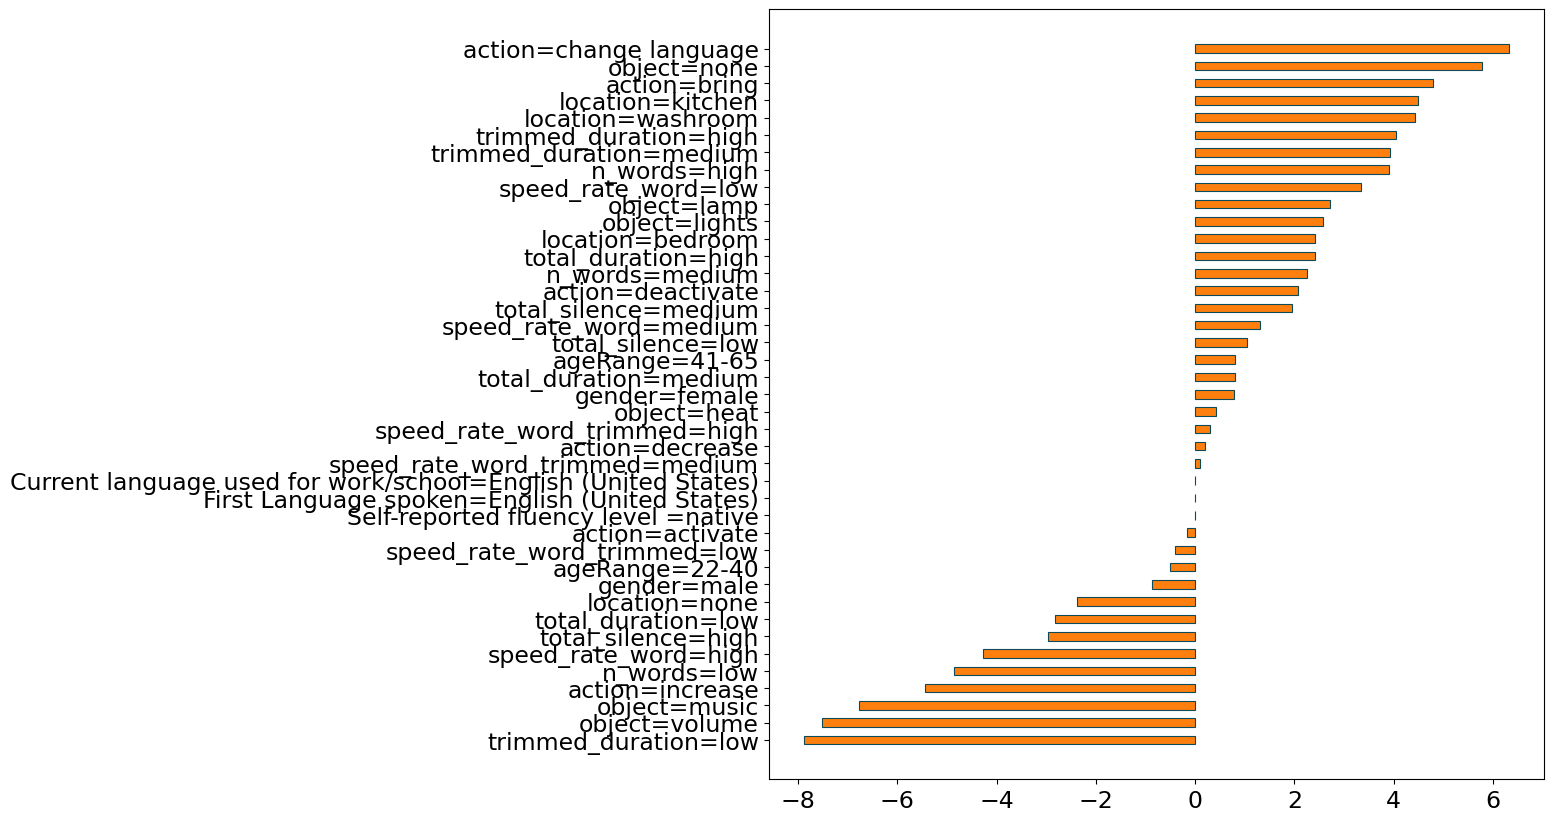

------------------------

Global Divergence


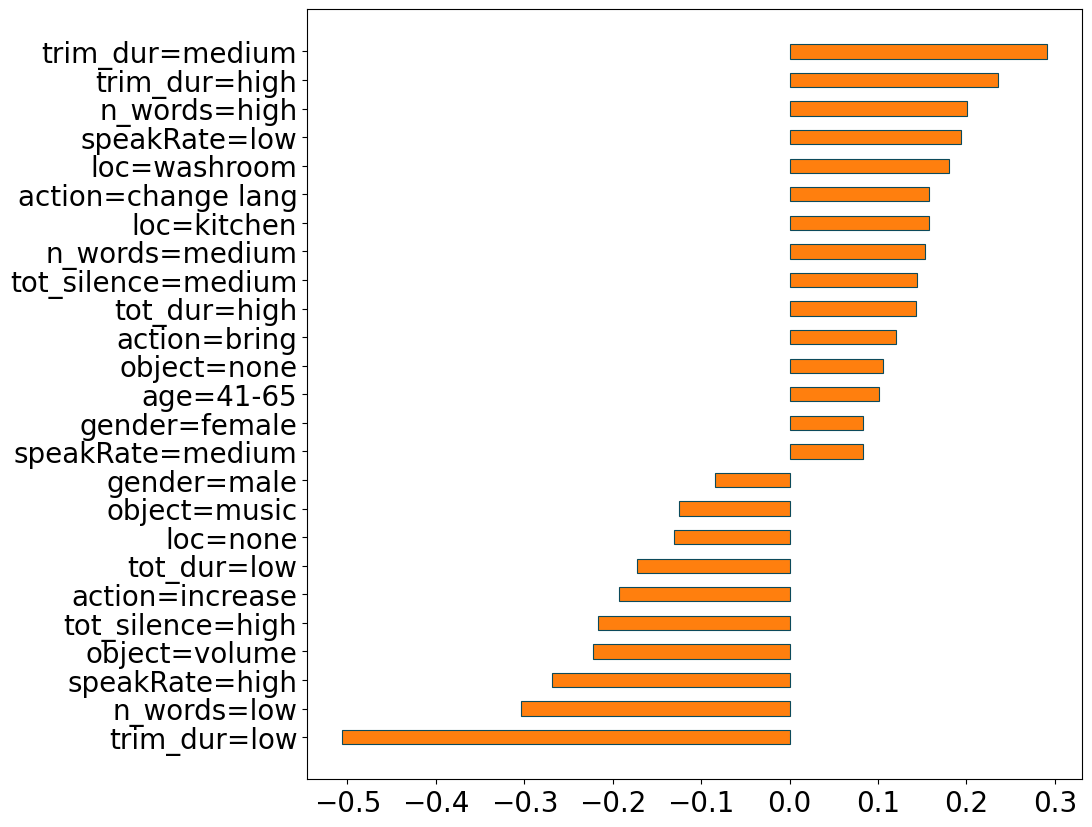

In [25]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_wav2b = fp_divergence_i.computeGlobalShapleyValue()

K= 25
topK_global_wavb = {k:v*100 for k,v in global_item_divergence_wav2b.items() 
                if k in sorted(global_item_divergence_wav2b, 
                key=lambda x: abs(global_item_divergence_wav2b[x]))[::-1][:K]}

plotShapleyValue(shapley_values=abbreviateDict(topK_global_wavb,abbreviations), 
                sizeFig=(10,10), labelsize=20, titlesize=20,
                saveFig=True, nameFig="plot_results/FSC/w2v2b_global_divergence.pdf")

# Divergence Wav2Vec2-Large

In [26]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [27]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  \
44217  age=22-40, gender=male, loc=none, speakRate=high, tot_silence=high   
37151                        action=increase, gender=male, speakRate=high   
27745                    action=activate, gender=male, speakRate_trim=low   

       support  accuracy  d_accuracy  t_value  
44217     0.03    74.790     -18.382     4.72  
37151     0.03    74.809     -18.362     4.94  
27745     0.04    74.834     -18.337     5.27

Problematic Speaker
0 96.67
1 54.55
2 44.74


In [28]:
## Retrieve Most Positively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  support  accuracy  d_accuracy  \
9230   action=change lang, speakRate_trim=high     0.07     100.0       6.828   
13801        action=change lang, gender=female     0.06     100.0       6.828   
21968            action=change lang, age=41-65     0.04     100.0       6.828   

       t_value  
9230     11.59  
13801    10.36  
21968     8.85

Problematic Speaker
0 0
1 0
2 0


Accuracy:  74.79
Δ_Acc:  -18.382


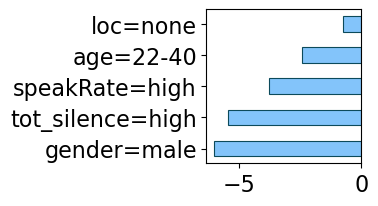

Accuracy:  91.667
Δ_Acc:  -1.505


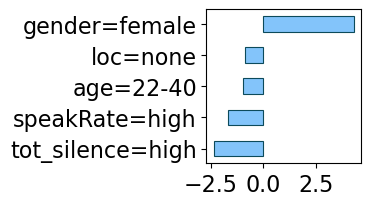

In [29]:
import warnings
warnings.filterwarnings('ignore')

## Subgroup {'age=22-40', 'gender=male', 'loc=none', 'speakRate=high', 'tot_silence=high'}
negative_itemset = frozenset({'ageRange=22-40', 'gender=male', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/w2v2l_most_negative_1.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=False)

## Subgroup {'age=22-40', 'gender=female', 'loc=none', 'speakRate=high', 'tot_silence=high'}
negative_itemset = frozenset({'ageRange=22-40', 'gender=female', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/w2v2l_most_negative_1_females.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=False)

Accuracy:  74.834
Δ_Acc:  -18.338


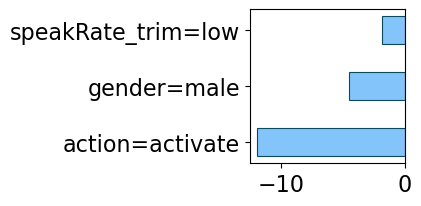

In [30]:
## Subgroup {'action=activate', 'speakRate_trimmed=low', 'gender=male'}
negative_itemset = frozenset({'action=activate', 'speed_rate_word_trimmed=low', 'gender=male'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Same subgroup but with female speakers --> Support: 0.25 
# negative_itemset = frozenset({'action=activate', 'speed_rate_word_trimmed=low', 'gender=female'})]

Accuracy:  96.667
Δ_Acc:  3.495


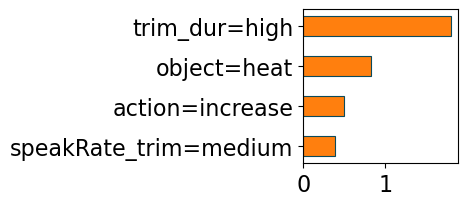

In [31]:
## Subgroup {'action=increase', 'object=heat', 'speakRate_trim=medium', 'trim_dur=high'}
positive_itemset = frozenset({'action=increase', 'object=heat', \
    'speed_rate_word_trimmed=medium', 'trimmed_duration=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16)

Accuracy:  75.188
Δ_Acc:  -17.984


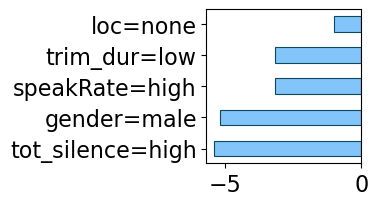

Accuracy:  89.41799999999999
Δ_Acc:  -3.754


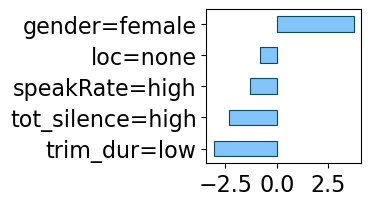

In [32]:
## {'speed_rate_word=high', 'location=none', 'total_silence=high', 'trimmed_duration=low'}
## Analysis of the gender effect

# Male Gender
negative_itemset = frozenset({'gender=male', 'speed_rate_word=high', \
    'location=none', 'total_silence=high', 'trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

# Female Gender
negative_itemset = frozenset({'gender=female', 'speed_rate_word=high', \
    'location=none', 'total_silence=high', 'trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Individual Divergence


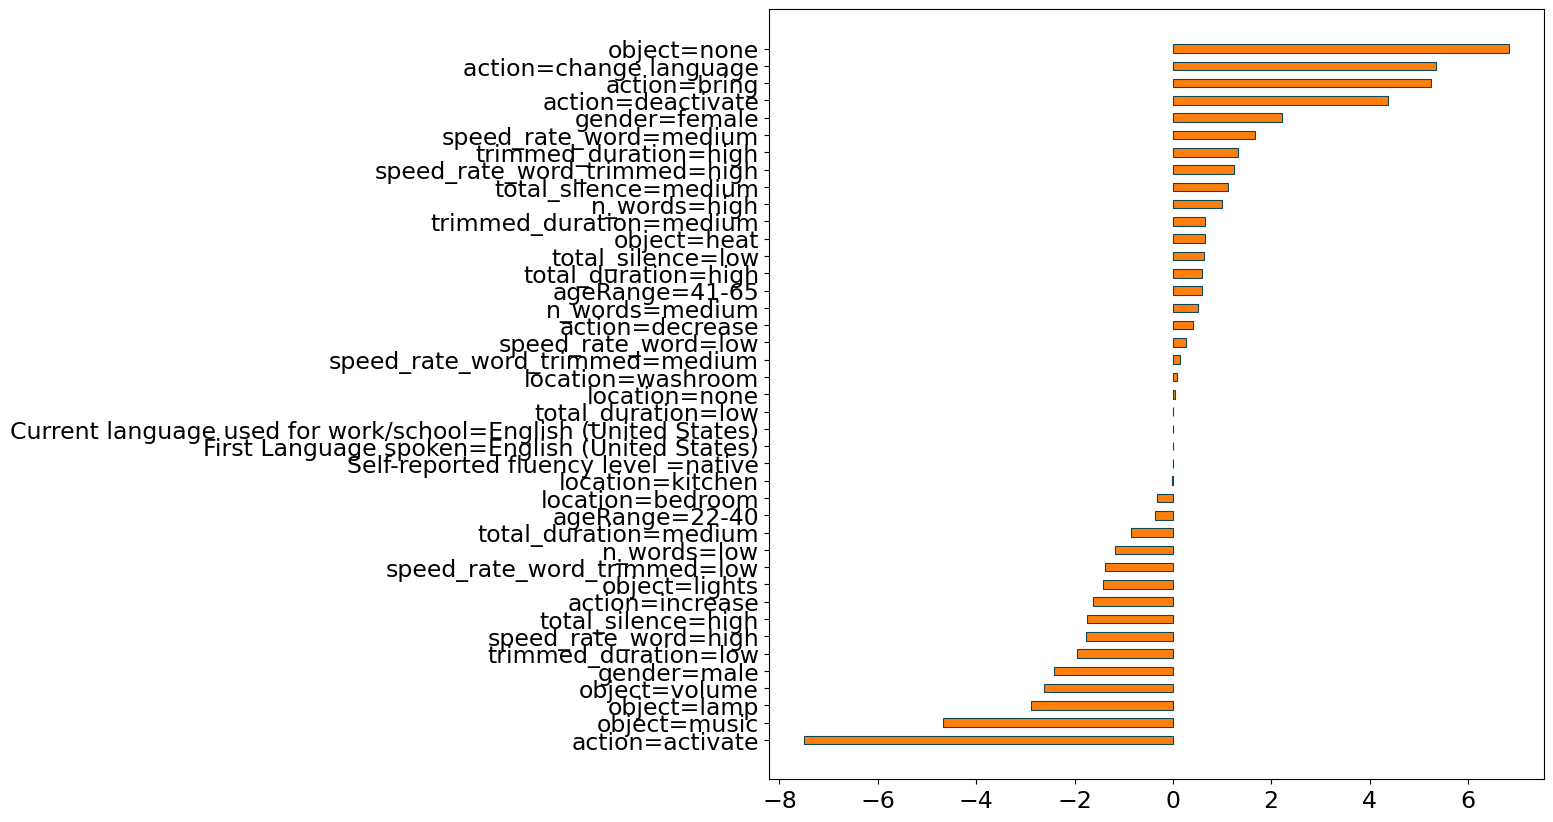

------------------------

Global Divergence


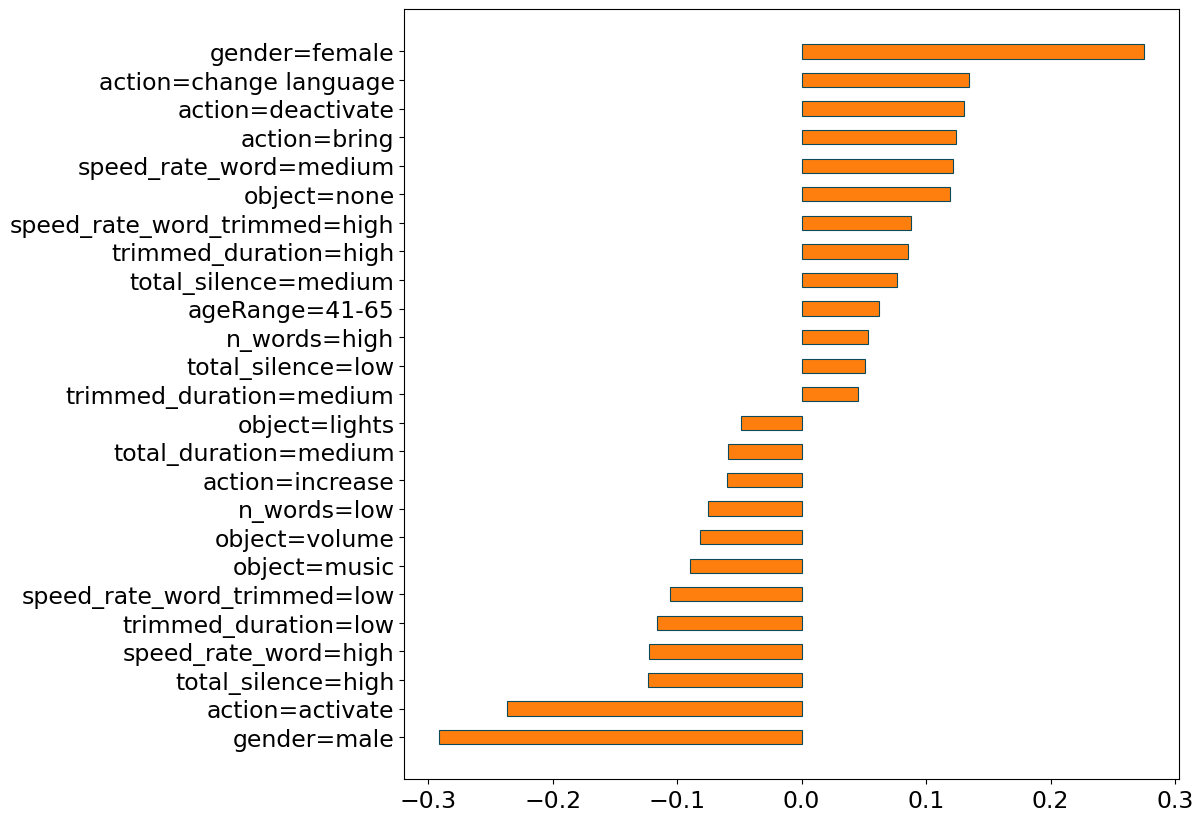

In [33]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_wav2l = fp_divergence_i.computeGlobalShapleyValue()

topK_global_wavl = {k:v*100 for k,v in global_item_divergence_wav2l.items() 
                if k in sorted(global_item_divergence_wav2l, 
                key=lambda x: abs(global_item_divergence_wav2l[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_wavl, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence Wav2Vec2-XLSR-53-Large

In [34]:
## Compute the divergence for wav2vec 2.0 xlsr-53 large (300m)
config = 'wav2vec2-large-xlsr-53'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [35]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  \
43710  action=increase, object=heat, speakRate_trim=medium, trim_dur=high   
41775                action=increase, n_words=high, speakRate_trim=medium   
31317               action=increase, speakRate_trim=medium, trim_dur=high   

       support  accuracy  d_accuracy  t_value  
43710     0.03    40.833     -49.246    11.00  
41775     0.03    40.984     -49.096    11.05  
31317     0.04    49.296     -40.783     9.75

Problematic Speaker
0 8.45
1 8.33
2 8.33


In [36]:
## Retrieve Most Positively Divergent Itemsets 
pr = FPdiv[::-1].head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  support  accuracy  \
8273   object=lights, tot_dur=high, tot_silence=high     0.07     100.0   
10402     gender=female, object=lights, tot_dur=high     0.07     100.0   
11107      age=22-40, object=lights, trim_dur=medium     0.06     100.0   

       d_accuracy  t_value  
8273        9.921    15.80  
10402       9.921    15.19  
11107       9.921    14.94

Problematic Speaker
0 0
1 0
2 0


Accuracy:  98.675
Δ_Acc:  8.596


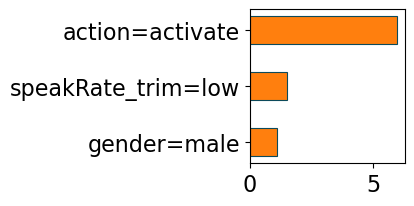

In [37]:
## Subgroup {'action=activate', 'speakRate_trimmed=low', 'gender=male'}
positive_itemset = frozenset({'action=activate', 'speed_rate_word_trimmed=low', 'gender=male'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_53_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## With gender=female, this subgroup has support: 0.25
# frozenset({'action=activate', 'speed_rate_word_trimmed=low', 'gender=female'})

Accuracy:  40.833000000000006
Δ_Acc:  -49.246


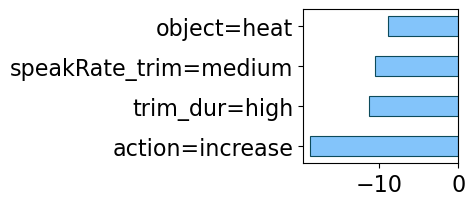

In [38]:
## Subgroup {'action=increase', 'object=heat', 'speakRate_trimmed=medium', 'trim_dur=high'}
negative_itemset = frozenset({'action=increase', 'object=heat', 'speed_rate_word_trimmed=medium', 'trimmed_duration=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_53_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Accuracy:  99.167
Δ_Acc:  9.088


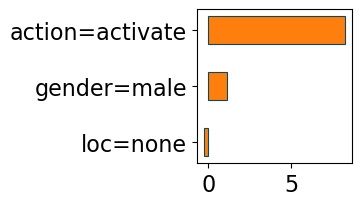

In [39]:
## Subgroup {'action=activate', 'loc=none', 'gender=male'}
negative_itemset = frozenset({'action=activate', 'location=none', 'gender=male'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_53_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

Individual Divergence


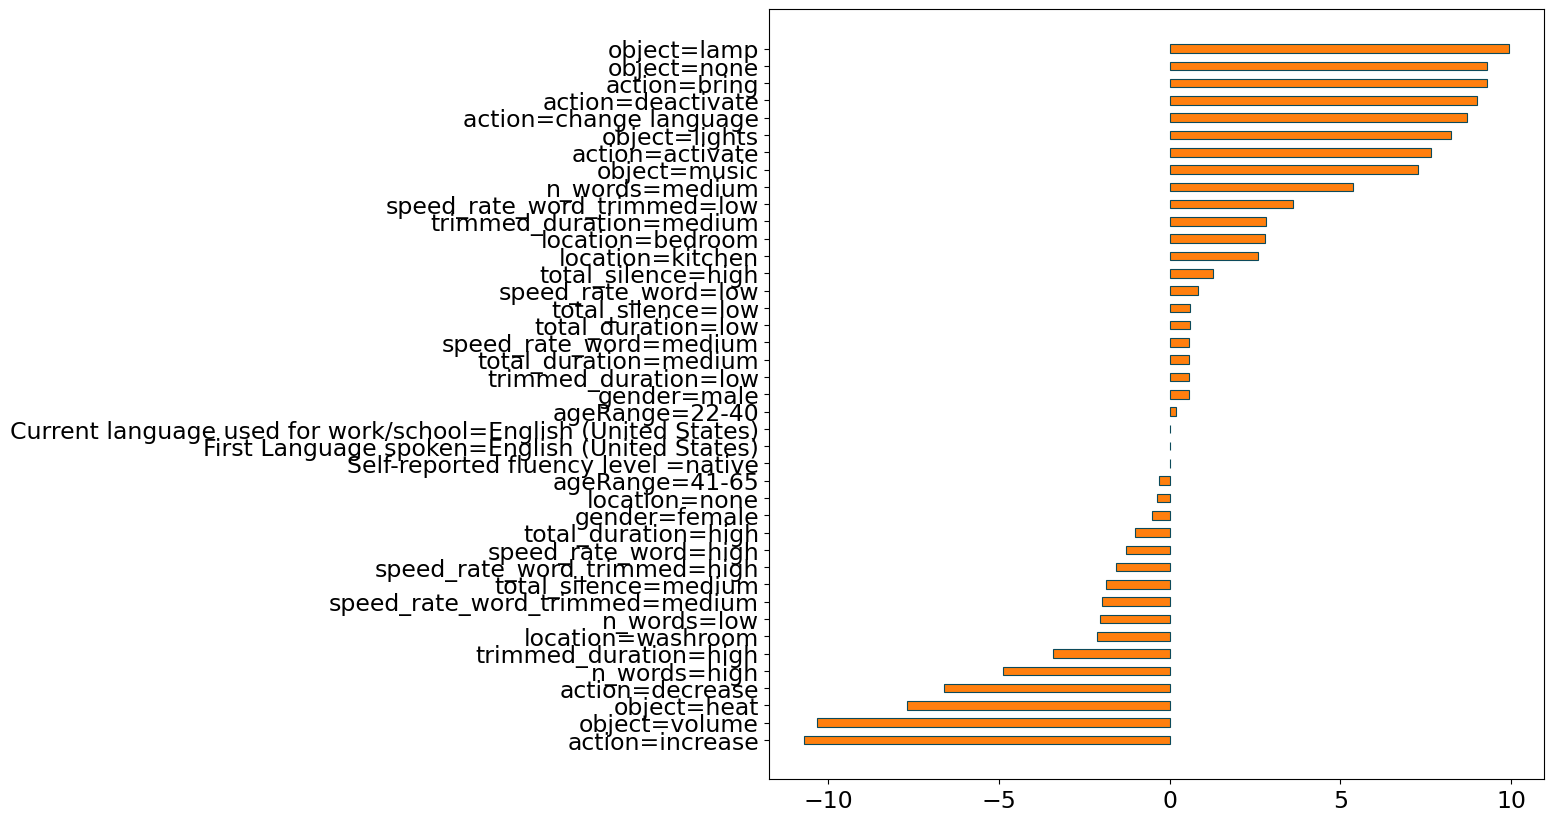

------------------------

Global Divergence


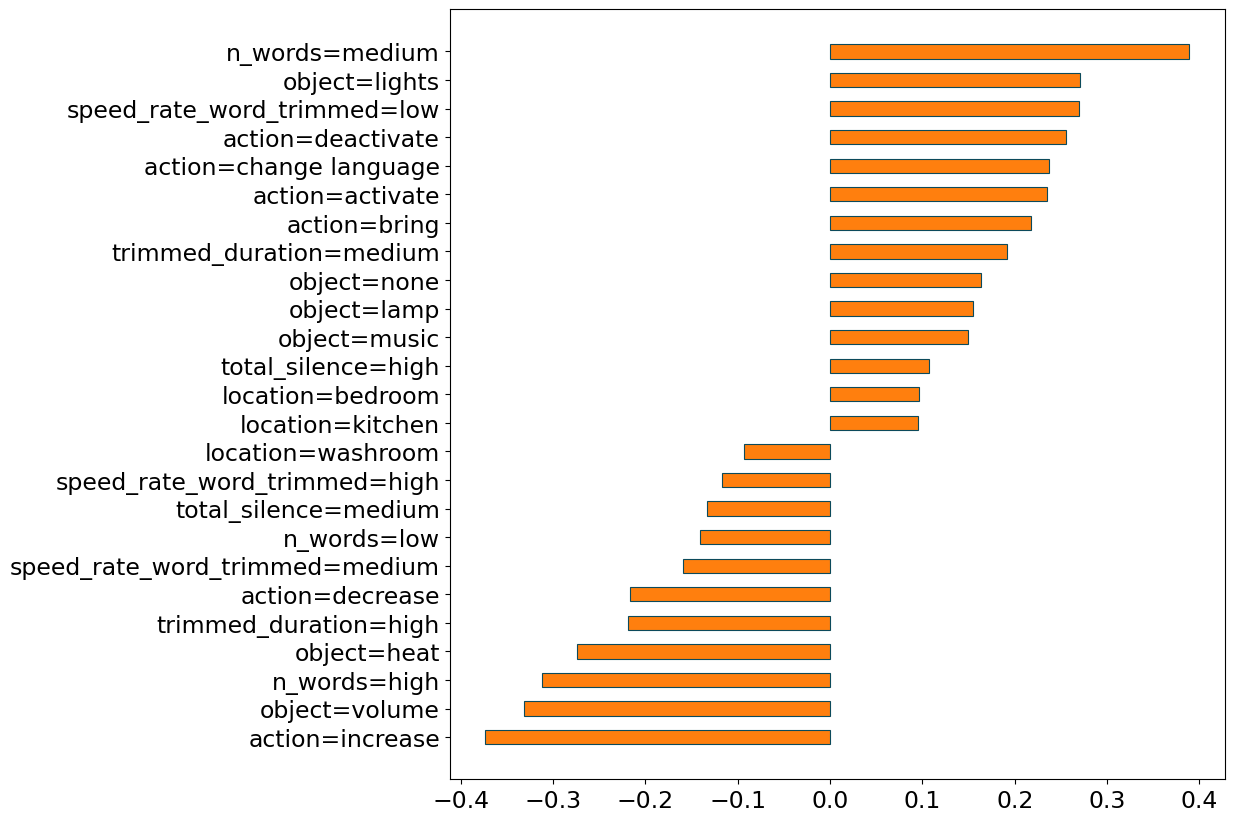

In [40]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_xlsr53 = fp_divergence_i.computeGlobalShapleyValue()

topK_global_xlsr53 = {k:v*100 for k,v in global_item_divergence_xlsr53.items() 
                if k in sorted(global_item_divergence_xlsr53, 
                key=lambda x: abs(global_item_divergence_xlsr53[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_xlsr53, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence Wav2Vec2-XLSR-128-300m

In [41]:
## Compute the divergence for wav2vec 2.0 xlsr-128 large (300m)
config = 'wav2vec2-xlsr-300m'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [42]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  \
46287  age=22-40, n_words=high, object=heat, speakRate=low, speakRate_trim=medium   
45415  age=22-40, gender=male, n_words=high, speakRate=low, speakRate_trim=medium   
33617             gender=male, n_words=high, speakRate=low, speakRate_trim=medium   

       support  accuracy  d_accuracy  t_value  
46287     0.03    92.241      -6.096     2.65  
45415     0.03    92.308      -6.030     2.64  
33617     0.04    92.701      -5.637     2.72

Problematic Speaker
0 22.22
1 22.22
2 20.0


In [43]:
## Retrieve Most Positively Divergent Itemsets 
pr = FPdiv[::-1].head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  support  accuracy  \
3871  gender=female, speakRate_trim=medium, tot_dur=high     0.10     100.0   
4284      n_words=medium, tot_dur=high, tot_silence=high     0.10     100.0   
4419                   age=22-40, loc=none, tot_dur=high     0.09     100.0   

      d_accuracy  t_value  
3871       1.662     4.24  
4284       1.662     4.09  
4419       1.662     4.05

Problematic Speaker
0 0
1 0
2 0


Accuracy:  99.248
Δ_Acc:  0.91


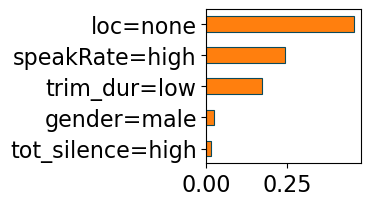

Accuracy:  98.942
Δ_Acc:  0.604


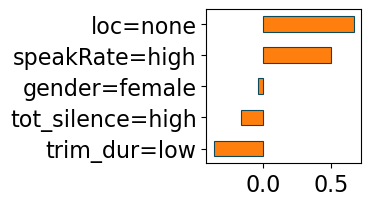

Accuracy:  99.068
Δ_Acc:  0.73


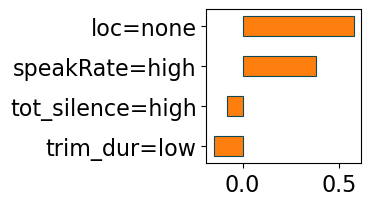

In [44]:
## Subgroup {'gender=male', 'speakRate=high', 'loc=none', 'tot_silence=high', 'trim_dur=low'}
positive_itemset = frozenset({'gender=male', 'speed_rate_word=high', 'location=none', 'total_silence=high', 'trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_128_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Subgroup {'gender=female', 'speakRate=high', 'loc=none', 'tot_silence=high', 'trim_dur=low'}
positive_itemset = frozenset({'gender=female', 'speed_rate_word=high', 'location=none', 'total_silence=high', 'trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_128_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Subgroup {'speakRate=high', 'loc=none', 'tot_silence=high', 'trim_dur=low'}
positive_itemset = frozenset({'speed_rate_word=high', 'location=none', 'total_silence=high', 'trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_128_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

Accuracy:  94.48299999999999
Δ_Acc:  -3.855


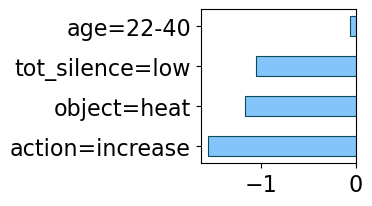

In [45]:
## Subgroup {'action=increase', 'object=heat', 'age=22-40', 'tot_silence=low'}
negative_itemset = frozenset({'action=increase', 'object=heat', 'ageRange=22-40', 'total_silence=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_128_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Accuracy:  99.167
Δ_Acc:  0.829


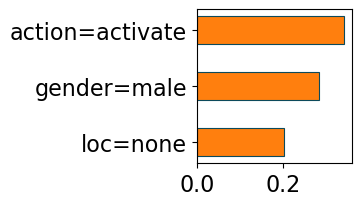

In [46]:
## Subgroup {'action=activate', 'loc=none', 'gender=male'}
positive_itemset = frozenset({'action=activate', 'location=none', 'gender=male'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - XLSR_128_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

Individual Divergence


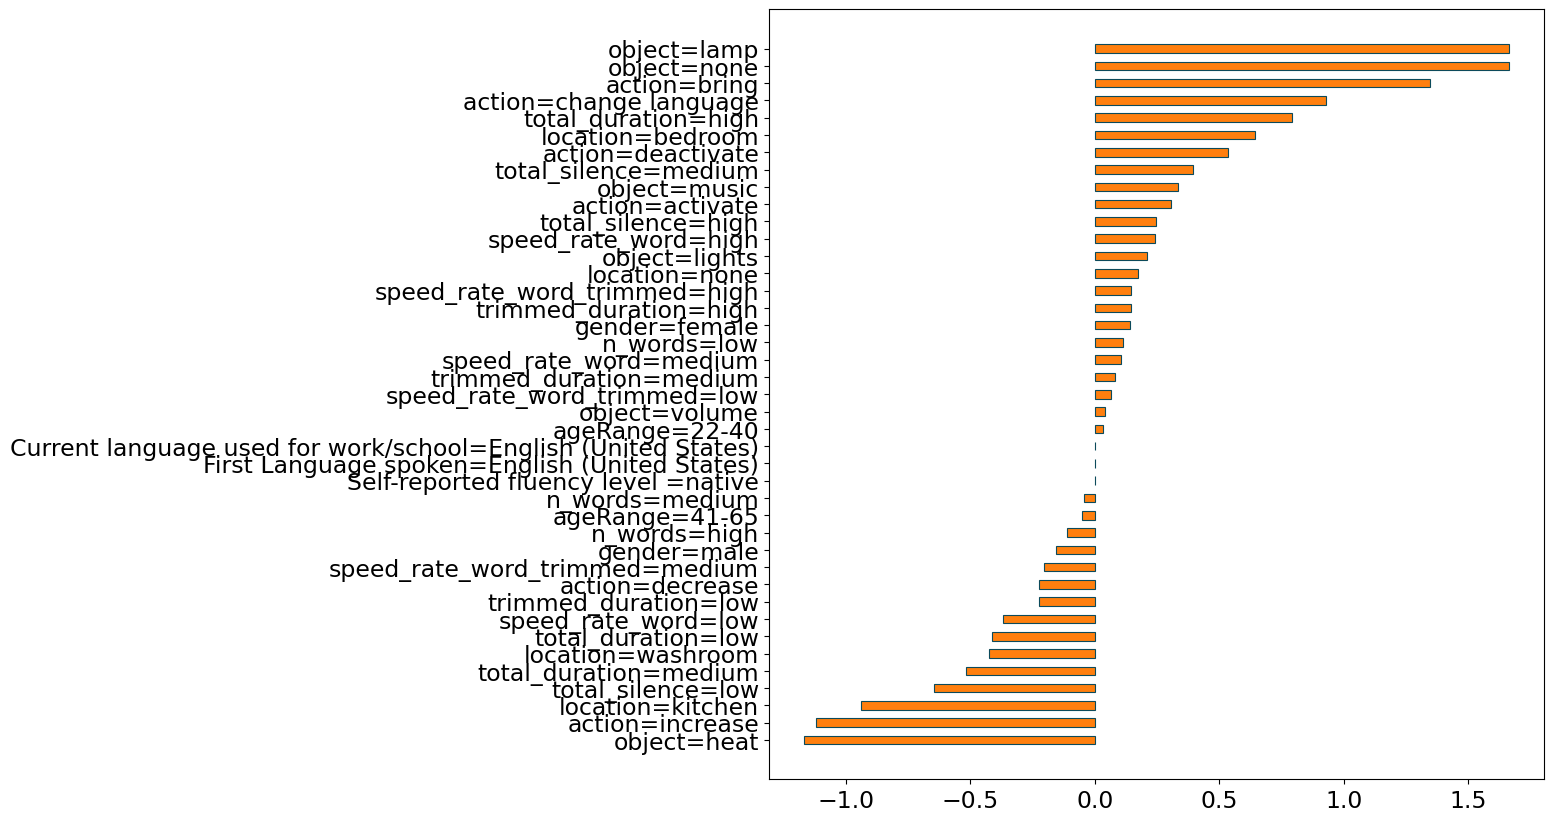

------------------------

Global Divergence


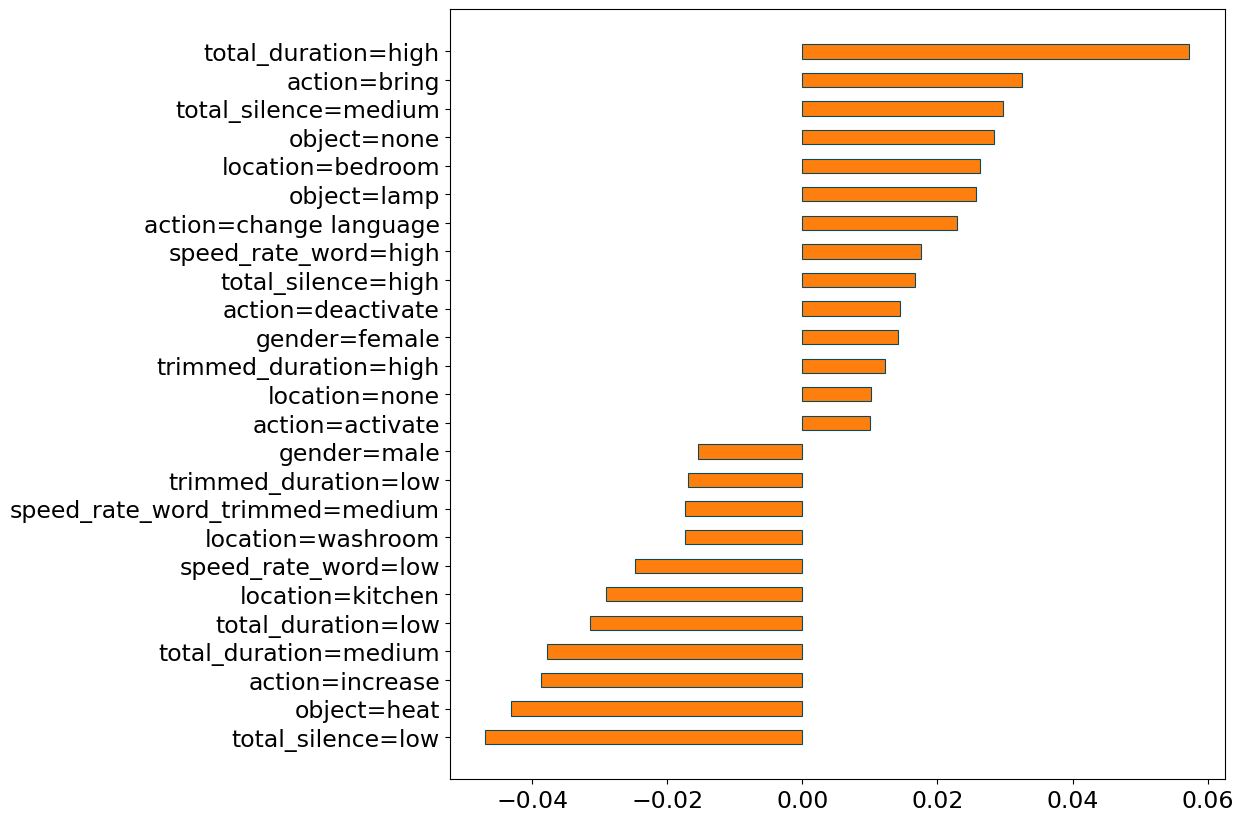

In [47]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_xlsr128 = fp_divergence_i.computeGlobalShapleyValue()

topK_global_xlsr128 = {k:v*100 for k,v in global_item_divergence_xlsr128.items() 
                if k in sorted(global_item_divergence_xlsr128, 
                key=lambda x: abs(global_item_divergence_xlsr128[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_xlsr128, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence HuBERT-Base

In [48]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [49]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  \
41759            age=22-40, gender=male, n_words=medium, tot_silence=high   
44217  age=22-40, gender=male, loc=none, speakRate=high, tot_silence=high   
42367                       age=22-40, gender=male, loc=none, object=heat   

       support  accuracy  d_accuracy  t_value  
41759     0.03    89.344      -9.074     3.41  
44217     0.03    89.916      -8.502     3.25  
42367     0.03    90.083      -8.335     3.24

Problematic Speaker
0 100.0
1 100.0
2 75.0


In [50]:
## Retrieve Most Positively Divergent Itemsets 
pr = FPdiv[::-1].head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  support  accuracy  \
3005             tot_silence=medium, trim_dur=medium     0.11     100.0   
3197                              action=change lang     0.11     100.0   
3394  loc=none, speakRate_trim=high, trim_dur=medium     0.10     100.0   

      d_accuracy  t_value  
3005       1.582     4.39  
3197       1.582     4.29  
3394       1.582     4.21

Problematic Speaker
0 0
1 0
2 0


Accuracy:  89.916
Δ_Acc:  -8.502


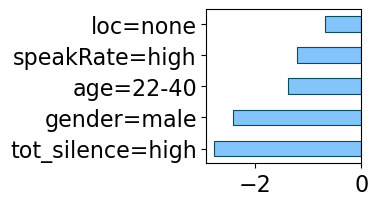

Accuracy:  98.214
Δ_Acc:  -0.204


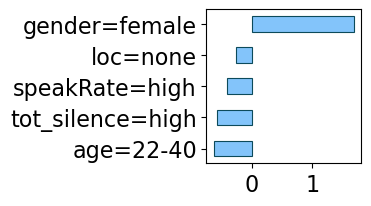

In [51]:
import warnings
warnings.filterwarnings('ignore')

## Subgroup {'age=22-40', 'gender=male', 'loc=none', 'speakRate=high', 'tot_silence=high'}
negative_itemset = frozenset({'ageRange=22-40', 'gender=male', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - HUBERT_BASE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/hubb_most_negative_1.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=False)

## Subgroup {'age=22-40', 'gender=female', 'loc=none', 'speakRate=high', 'tot_silence=high'}
negative_itemset = frozenset({'ageRange=22-40', 'gender=female', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - HUBERT_BASE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/hubb_most_negative_1_females.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=False)

Individual Divergence


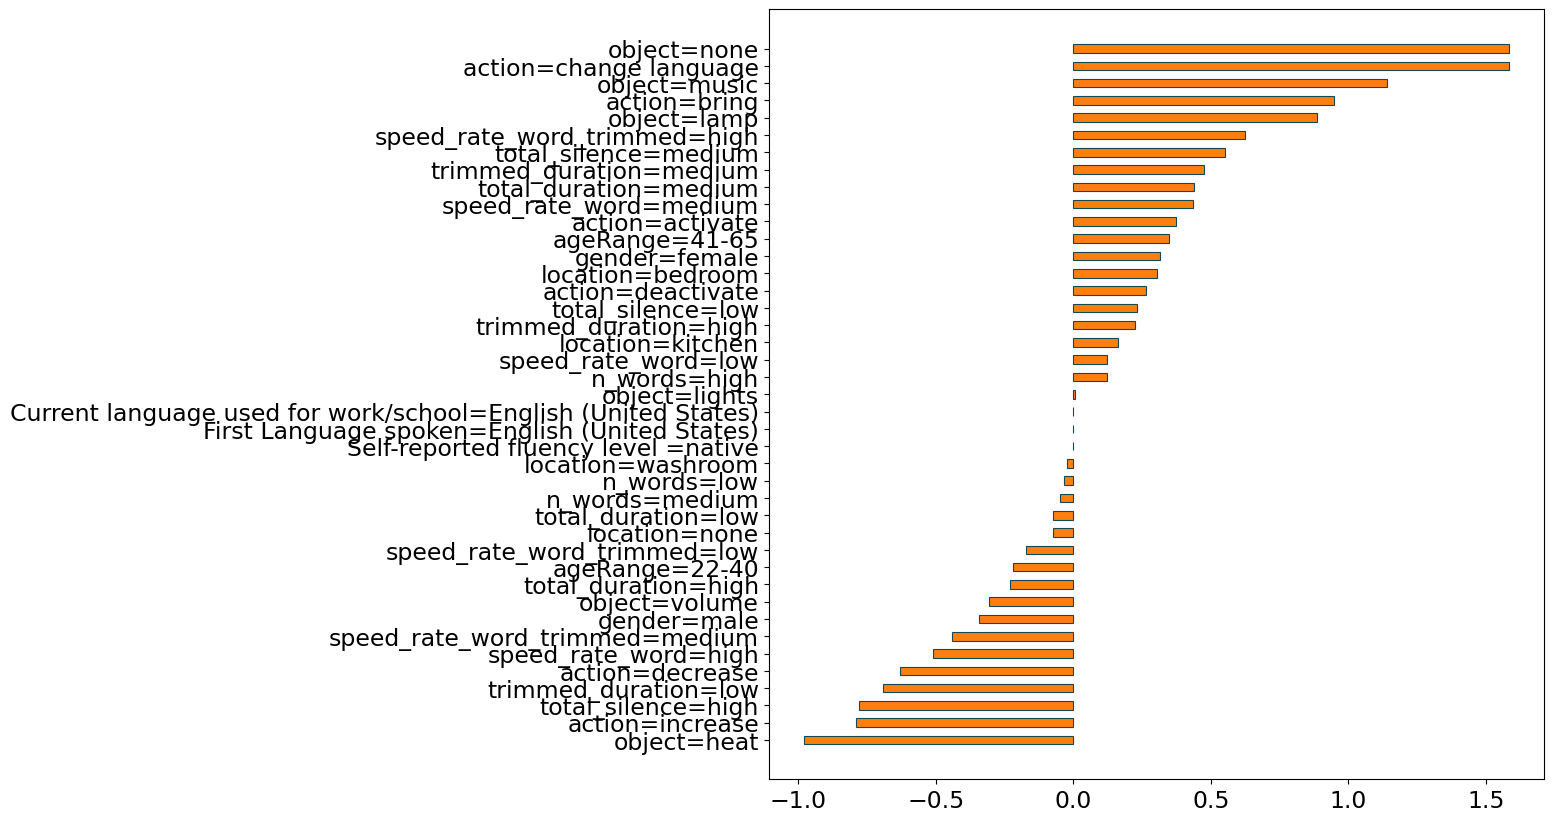

------------------------

Global Divergence


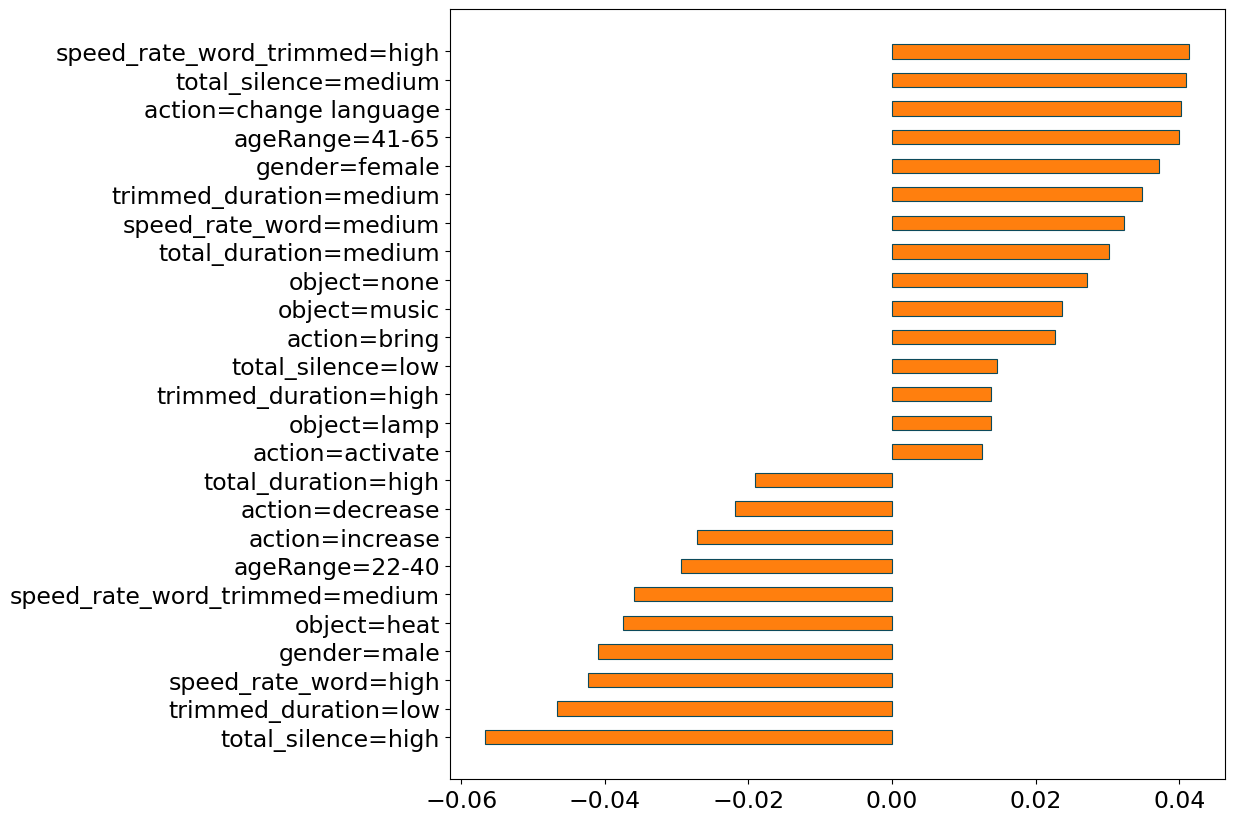

In [52]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_hubb = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubb = {k:v*100 for k,v in global_item_divergence_hubb.items() 
                if k in sorted(global_item_divergence_hubb, 
                key=lambda x: abs(global_item_divergence_hubb[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubb, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence HuBERT-Large

In [53]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [54]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  \
31714            speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low   
35295  loc=none, speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low   
27706                                speakRate=low, tot_silence=low, trim_dur=low   

       support  accuracy  d_accuracy  t_value  
31714     0.04    86.525     -11.972     4.30  
35295     0.04    87.313     -11.184     4.03  
27706     0.04    87.500     -10.997     4.23

Problematic Speaker
0 5.26
1 5.88
2 5.26


In [55]:
## Retrieve Most Positively Divergent Itemsets 
pr = FPdiv[::-1].head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l.head(n))

## Problematic Speaker
print("Problematic Speaker")
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

itemsets  support  accuracy  \
1144  gender=female, tot_dur=high, trim_dur=high     0.16     100.0   
2024              speakRate=medium, tot_dur=high     0.13     100.0   
2553        speakRate=medium, tot_silence=medium     0.12     100.0   

      d_accuracy  t_value  
1144       1.503     5.35  
2024       1.503     4.64  
2553       1.503     4.36

Problematic Speaker
0 0
1 0
2 0


Accuracy:  98.319
Δ_Acc:  -0.178


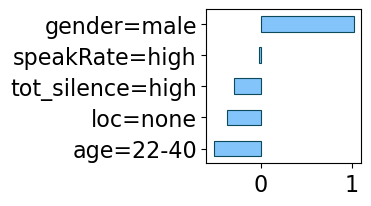

Accuracy:  94.048
Δ_Acc:  -4.449


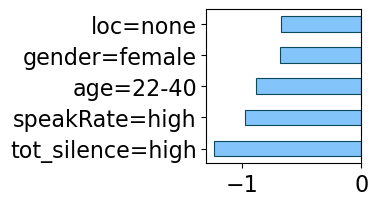

In [56]:
## Subgroup {'age=22-40', 'gender=male', 'loc=none', 'speakRate=high', 'tot_silence=high'}
negative_itemset = frozenset({'ageRange=22-40', 'gender=male', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == negative_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - HUBERT_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/hubl_most_negative_1.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=False)

## Subgroup {'age=22-40', 'gender=female', 'loc=none', 'speakRate=high', 'tot_silence=high'}
positive_itemset = frozenset({'ageRange=22-40', 'gender=female', 'location=none', 'speed_rate_word=high', 'total_silence=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr = FPdiv.copy()
acc = pr[pr['itemsets'] == positive_itemset].iloc[0]['accuracy']*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - HUBERT_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = f"plot_results/FSC/hubl_most_negative_1_females.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                nameFig=name_fig, saveFig=False)

Individual Divergence


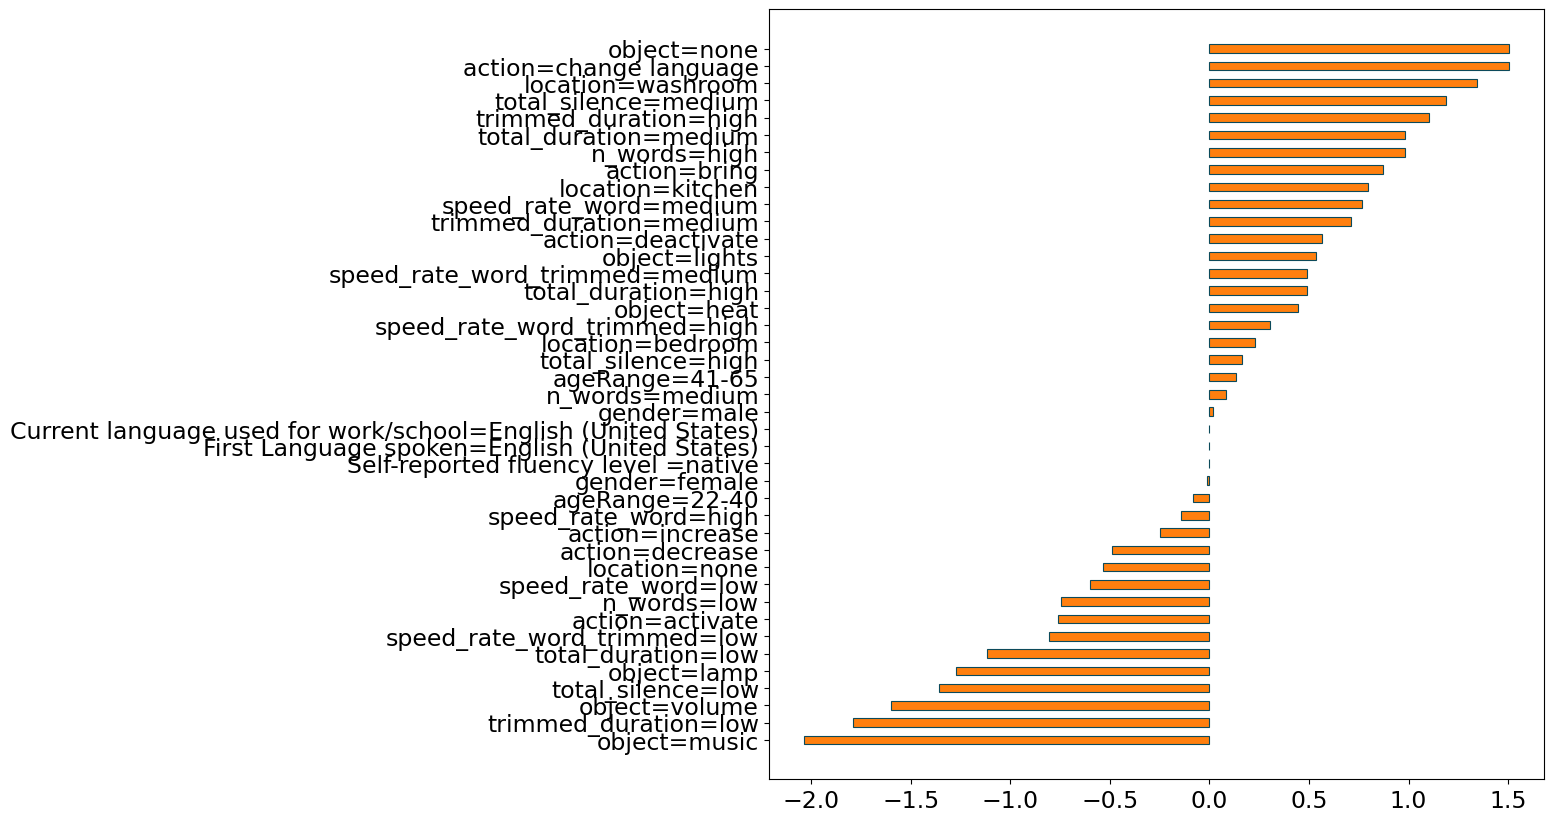

------------------------

Global Divergence


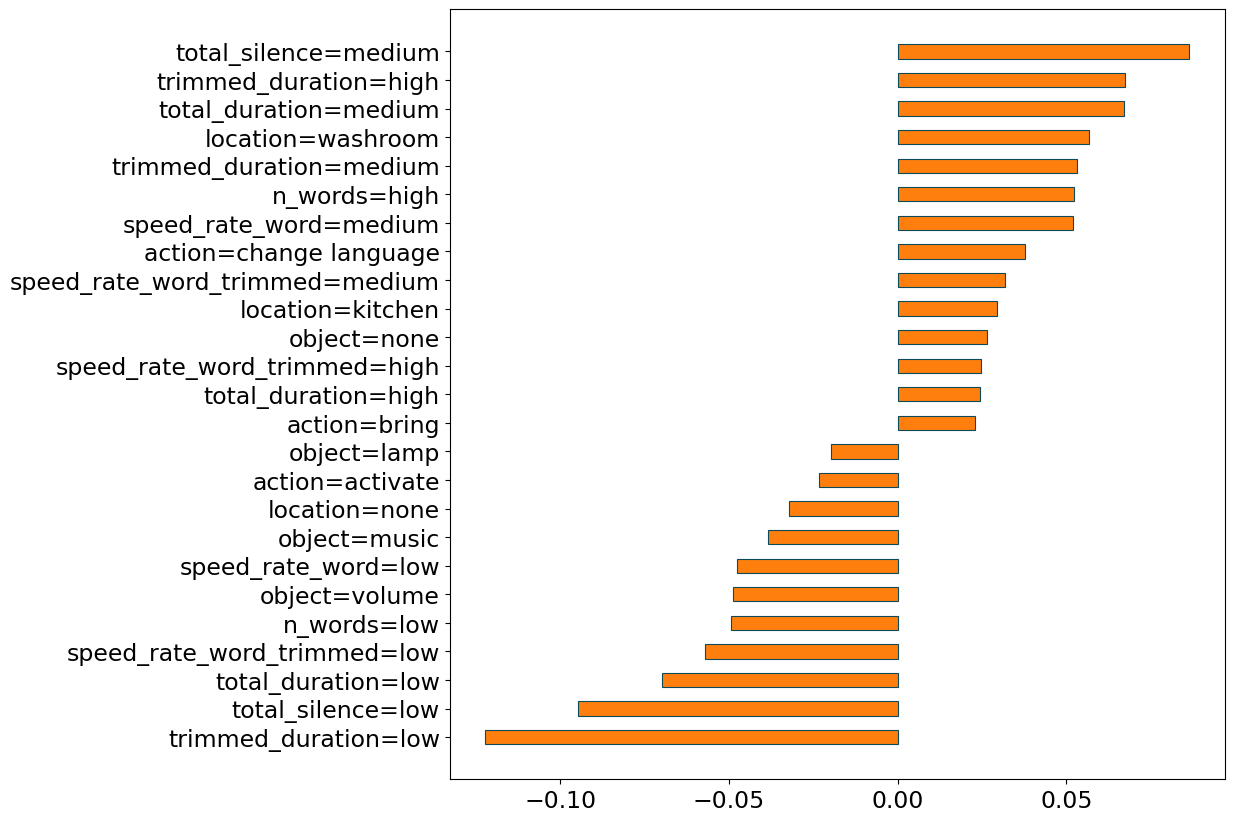

In [57]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_hubl = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubl = {k:v*100 for k,v in global_item_divergence_hubl.items() 
                if k in sorted(global_item_divergence_hubl, 
                key=lambda x: abs(global_item_divergence_hubl[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubl, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence difference Wav2Vec2-Base vs Wav2Vec2-Large

In [58]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_w2l.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(wlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [59]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_large"] - merged["accuracy_base"]
merged["difference"] = merged["accuracy_large"] - merged["accuracy_base"]

In [60]:
## Create "Gain Base-Large W2V2" df and compute divergence
base_large_gain_df = merged[['support', '#errors_large', '#corrects_large', 'accuracy_large',
       'd_accuracy_large', 't_value_large', 'support_count_large', 'length_large'] \
       + [diff, "difference", "accuracy_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [61]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_base', 'accuracy_large', 'support']

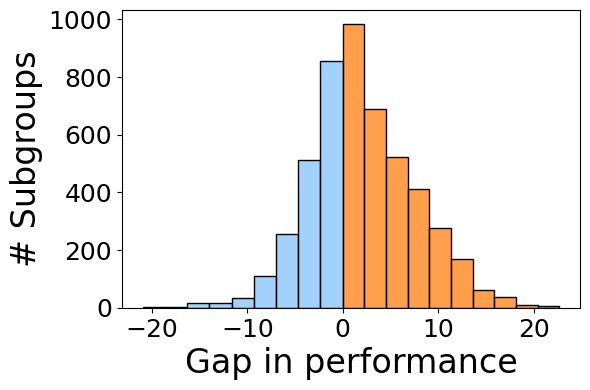

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(list_diff_neg, bins=9, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/FSC/distribution_gain_w2v2_base_large.pdf")

## Stats

In [63]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for Wav2Vec2-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for Wav2Vec2-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
4.3573
Greater
63.7506
Lower
31.8921


## Gain > 0

In [64]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0  action=increase, loc=none, speakRate_trim=low, tot_dur=low, trim_dur=low   
1           action=increase, age=22-40, loc=none, tot_dur=low, trim_dur=low   

   d_difference  accuracy_base  accuracy_large  support  
0         22.69          75.63           98.32     0.03  
1         22.01          70.44           92.45     0.04

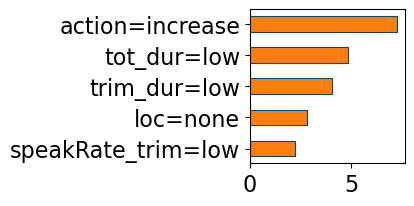

In [65]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [66]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  d_difference  \
0       action=activate, gender=male, speakRate=low        -20.97   
1  action=activate, gender=male, speakRate_trim=low        -16.56   

   accuracy_base  accuracy_large  support  
0          96.77           75.81     0.03  
1          91.39           74.83     0.04

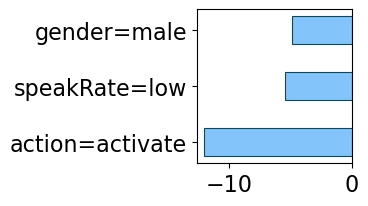

In [67]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)         

## Gain = 0 

In [68]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support_large"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  d_difference  \
3167  action=increase, gender=male, n_words=low, speakRate=high           0.0   
3166   action=increase, gender=male, n_words=low, object=volume           0.0   

      accuracy_base  accuracy_large   support  support_large  
3167          75.41           75.41  0.032165           0.03  
3166          78.15           78.15  0.031374           0.03

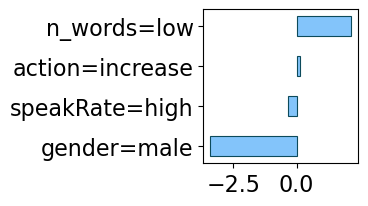

In [69]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [70]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and Wav2Vec2-Large
global_item_divergence_w2b_w2l = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_w2l = {k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(global_item_divergence_w2b_w2l, 
                        key=lambda x: abs(global_item_divergence_w2b_w2l[x]))[::-1][:K]}

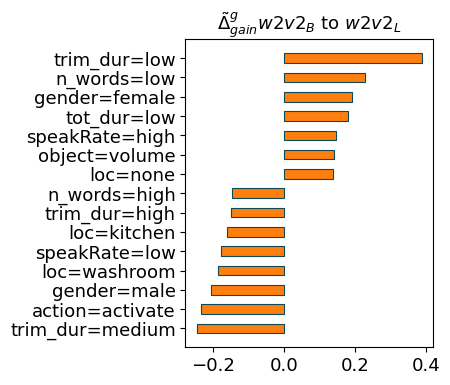

In [71]:
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

## Plot and Save the image 
topK_global_w2b_w2l_abbr = abbreviateDict(topK_global_w2b_w2l, abbreviations)
topK_global_w2b_w2l_abbr = {k:v*100 for k,v in topK_global_w2b_w2l_abbr.items()}
name_fig = "plot_results/FSC/global_shapley_gain_w2b_w2l.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_w2l_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} w2v2_{B}$ to $w2v2_{L}$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec2-Base vs Hubert-Base

In [72]:
## Compute the divergence for Hubert-Base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(hbase, lsuffix='_w2b', rsuffix='_hb')
merged = merged.rename(columns={'support_hb': 'support'})

In [73]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_hb"] - merged["accuracy_w2b"]
merged["difference"] = merged["accuracy_hb"] - merged["accuracy_w2b"]

In [74]:
## Create "Gain W2Base-HBase" df and compute divergence
hbase_w2base_gain_df = merged[['support', '#errors_hb', '#corrects_hb', 'accuracy_hb',
       'd_accuracy_hb', 't_value_hb', 'support_count_hb', 'length_hb'] \
       + [diff, "difference", "accuracy_w2b"]]
hbase_w2base_gain_df = hbase_w2base_gain_df.rename(columns={'length_hb':'length'})
hbase_w2base_gain_df = hbase_w2base_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(hbase_w2base_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [75]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_w2b', 'accuracy_hb', 'support']

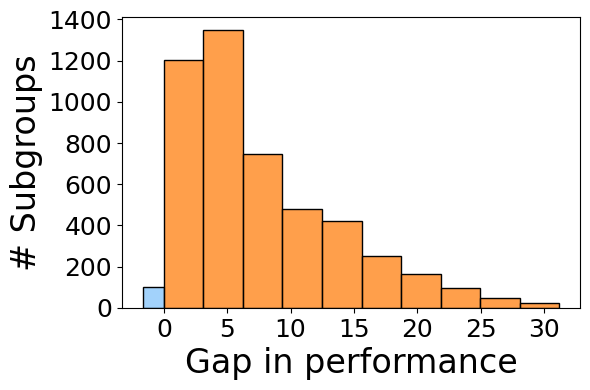

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=1, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/FSC/distribution_gain_w2v2_hub_base.pdf")

## Stats

In [77]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),3))

# Percentage of itemsets for which performance are greater for Hubert-Base
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 3))

# Percentage of itemsets for which performance are lower for Hubert-Base
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]),3))

Equal
1.927
Greater
97.034
Lower
1.039


## Gain > 0

In [78]:
## Retrieve the data cohorts for which Hubert-Base performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hb"] = (pr["accuracy_hb"]*100).round(2)
pr["accuracy_w2b"] = (pr["accuracy_w2b"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0  gender=male, loc=none, n_words=low, tot_silence=high, trim_dur=low   
1    age=22-40, gender=male, n_words=low, object=volume, trim_dur=low   

   d_difference  accuracy_w2b  accuracy_hb  support  
0         31.20         64.00        95.20     0.03  
1         31.11         67.41        98.52     0.04

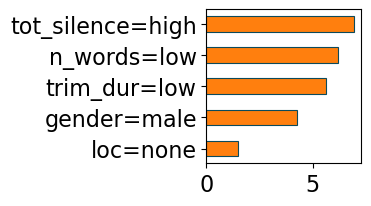

In [79]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [80]:
## Retrieve the data cohorts for which Hubert-Base performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hb"] = (pr["accuracy_hb"]*100).round(2)
pr["accuracy_w2b"] = (pr["accuracy_w2b"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0                        action=decrease, age=22-40, loc=washroom   
1  action=decrease, gender=female, tot_dur=high, tot_silence=high   

   d_difference  accuracy_w2b  accuracy_hb  support  
0         -1.68        100.00        98.32     0.03  
1         -0.88         98.25        97.37     0.03

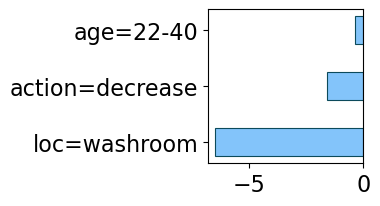

In [81]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [82]:
## Retrieve the data cohorts for which Hubert-Base performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hb"] = (pr["accuracy_hb"]*100).round(2)
pr["accuracy_w2b"] = (pr["accuracy_w2b"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]

pr = pr.sort_values("d_difference").sort_values("accuracy_hb")
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  d_difference  \
4785   action=decrease, n_words=high, speakRate_trim=medium           0.0   
4784  action=decrease, speakRate_trim=medium, trim_dur=high           0.0   

      accuracy_w2b  accuracy_hb  support  
4785         95.49        95.49     0.04  
4784         96.23        96.23     0.04

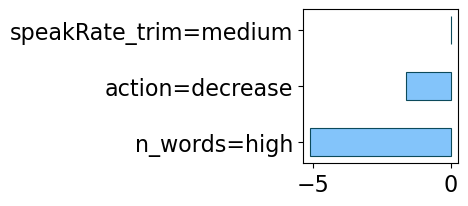

In [83]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [84]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and Hubert-Base
global_item_divergence_w2b_hb = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_hb = {k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(global_item_divergence_w2b_hb, 
                        key=lambda x: abs(global_item_divergence_w2b_hb[x]))[::-1][:K]}

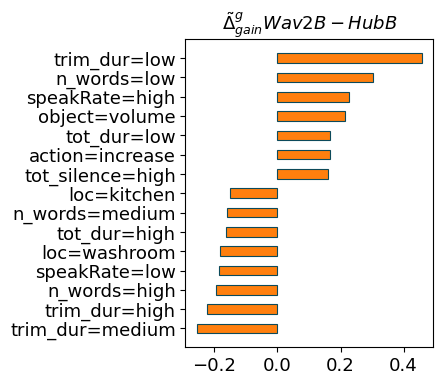

In [85]:
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

## Plot and Save the Image
topK_global_w2b_hb_abbr = abbreviateDict(topK_global_w2b_hb, abbreviations)
topK_global_w2b_hb_abbr = {k:v*100 for k,v in topK_global_w2b_hb_abbr.items()}
name_fig = "plot_results/FSC/global_shapley_gain_w2b_hb.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_hb_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2B - HubB$",
                nameFig=name_fig, saveFig=False)

In [86]:
## Take the K Global Shapley Values for HubB-WavB starting from the top-K of WavL-WavB
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)
topK_global_w2b_hb_1_abbr = {k:v*100 for k,v in topK_global_w2b_hb_1_abbr.items()}

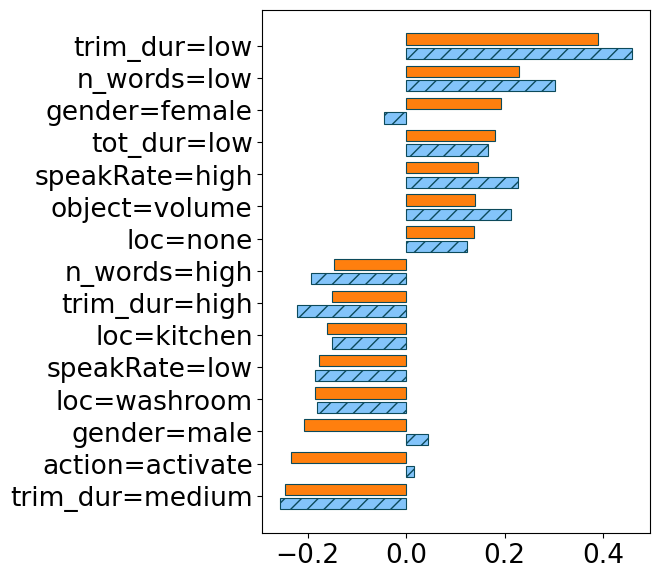

In [87]:
name_fig = f"plot_results/FSC/global_shapley_gain_w2b_w2l_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/FSC/global_shapley_gain_w2b_w2l_hb_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, 
            shapley_values_2=topK_global_w2b_hb_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec2-Large Mono vs XLSR-53

In [88]:
## Compute the divergence for XLSR-53
config = 'wav2vec2-large-xlsr-53'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l_xlsr53 = fp_divergence_i.getDivergence(th_redundancy=None).copy()
w2l_xlsr53 = FPdiv_w2l_xlsr53.set_index("itemsets")

## Compute the divergence for wav2vec 2.0 large monolingual
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l_mono = fp_divergence_i.getDivergence(th_redundancy=None).copy()
w2l_mono = FPdiv_w2l_mono.set_index("itemsets")

## Merge the df
merged = w2l_xlsr53.join(w2l_mono, lsuffix='_w2l-xlsr53', rsuffix='_w2l-mono')
merged = merged.rename(columns={'support_w2l-mono': 'support'})

In [89]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_w2l-mono"] - merged["accuracy_w2l-xlsr53"]
merged["difference"] = merged["accuracy_w2l-mono"] - merged["accuracy_w2l-xlsr53"]

In [90]:
## Create "Gain wav2vec 2.0 large monolingual vs XLSR-53" df and compute divergence
w2lmono_w2lxlsr53_gain_df = merged[['support', '#errors_w2l-mono', '#corrects_w2l-mono', 'accuracy_w2l-mono',
       'd_accuracy_w2l-mono', 't_value_w2l-mono', 'support_count_w2l-mono', 'length_w2l-mono'] \
       + [diff, "difference", "accuracy_w2l-xlsr53"]]
w2lmono_w2lxlsr53_gain_df = w2lmono_w2lxlsr53_gain_df.rename(columns={'length_w2l-mono':'length'})
w2lmono_w2lxlsr53_gain_df = w2lmono_w2lxlsr53_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(w2lmono_w2lxlsr53_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [91]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_w2l-mono', 'accuracy_w2l-xlsr53', 'support']

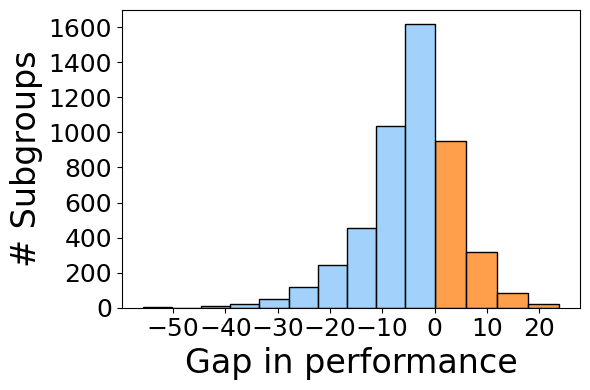

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_pos = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_pos = [i * -100 for i in list_diff_pos]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_pos, bins=4, kde=False, ax=ax, color='C01', palette="colorblind")
list_diff_neg = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_neg = [i * -100 for i in list_diff_neg]
sns.histplot(list_diff_neg, bins=10, kde=False, ax=ax, color='#83C4FA', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/FSC/distribution_gain_w2v2l_xlsr53.pdf")

## Stats

In [93]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),3))

# Percentage of itemsets for which performance are greater for the monolingual model
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 3))

# Percentage of itemsets for which performance are lower for the monolingual model
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]),3))

Equal
2.116
Greater
72.297
Lower
25.588


## Gain > 0

In [94]:
## Retrieve the data cohorts for which wav2vec 2.0 large monolingual performs better than XLSR-53
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_w2l-xlsr53"] = (pr["accuracy_w2l-xlsr53"]*100).round(2)
pr["accuracy_w2l-mono"] = (pr["accuracy_w2l-mono"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0  action=increase, object=heat, speakRate_trim=medium, trim_dur=high   
1                action=increase, n_words=high, speakRate_trim=medium   

   d_difference  accuracy_w2l-mono  accuracy_w2l-xlsr53  support  
0         55.83              96.67                40.83     0.03  
1         54.92              95.90                40.98     0.03

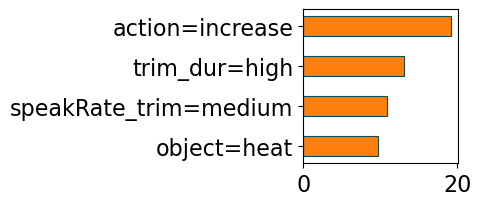

In [95]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = "plot_results/FSC/shapley_gain_wlmono_xlsr53.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, \
                nameFig=name_fig, saveFig=True)

## Gain < 0 

In [96]:
## Retrieve the data cohorts for which wav2vec 2.0 large monolingual performs worse than XLSR-53
pr = compare_performance[cols][::-1].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_w2l-xlsr53"] = (pr["accuracy_w2l-xlsr53"]*100).round(2)
pr["accuracy_w2l-mono"] = (pr["accuracy_w2l-mono"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  d_difference  \
0  action=activate, gender=male, speakRate_trim=low        -23.84   
1       action=activate, gender=male, speakRate=low        -23.39   

   accuracy_w2l-mono  accuracy_w2l-xlsr53  support  
0              74.83                98.68     0.04  
1              75.81                99.19     0.03

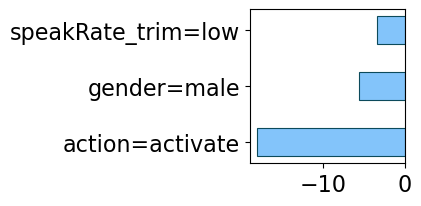

In [97]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = "plot_results/FSC/shapley_negative_gain_wlmono_xlsr53.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                saveFig=False, nameFig=name_fig)

## Gain = 0 

In [98]:
## Retrieve the data cohorts for which XLSR-53 performs equal to wav2vec 2.0 large monolingual
pr = compare_performance[cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_w2l-xlsr53"] = (pr["accuracy_w2l-xlsr53"]*100).round(2)
pr["accuracy_w2l-mono"] = (pr["accuracy_w2l-mono"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l = pr_l.sort_values("d_difference").sort_values("accuracy_w2l-mono")
pr_l

itemsets  d_difference  \
3477  gender=female, tot_silence=high, trim_dur=low           0.0   
3476                     loc=kitchen, speakRate=low           0.0   

      accuracy_w2l-mono  accuracy_w2l-xlsr53  support  
3477              91.09                91.09     0.07  
3476              91.90                91.90     0.07

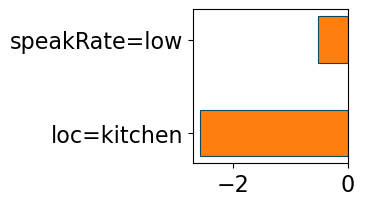

In [99]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Global Shapley value

In [100]:
## Compute the top-K global shapley values related to the gain in performance between wav2vec 2.0 large monolingual and XLSR-53
global_item_divergence_w2lmono_w2lxlsr53 = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2lmono_w2lxlsr53 = {k:v for k,v in global_item_divergence_w2lmono_w2lxlsr53.items() \
                        if k in sorted(global_item_divergence_w2lmono_w2lxlsr53, 
                        key=lambda x: abs(global_item_divergence_w2lmono_w2lxlsr53[x]))[::-1][:K]}

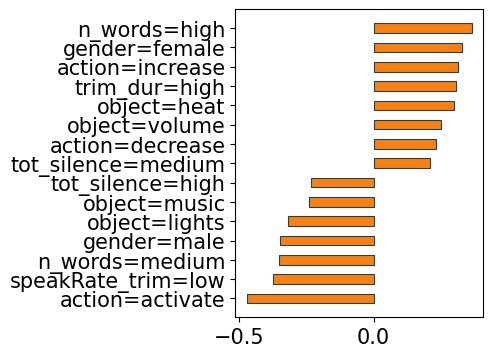

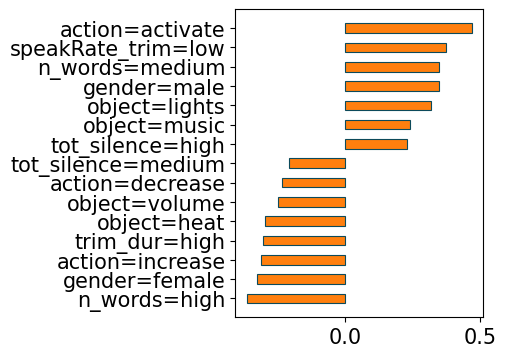

In [101]:
sizeFig = (3.2,4)
labelsize = 15
titlesize = 15

## Plot and Save the Image
topK_global_w2lmono_w2lxlsr53_abbr = abbreviateDict(topK_global_w2lmono_w2lxlsr53, abbreviations)
topK_global_w2lmono_w2lxlsr53_abbr = {k:v*100 for k,v in topK_global_w2lmono_w2lxlsr53_abbr.items()}
name_fig = "plot_results/FSC/global_shapley_gain_w2lxlsr53_w2lmono.pdf"
plotShapleyValue(shapley_values=topK_global_w2lmono_w2lxlsr53_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                # title = r"$\tilde{\Delta}^g_{gain}$ XLSR53 to Wav2L mono",
                nameFig=name_fig, saveFig=False)

## invert all the values
topK_global_w2lmono_w2lxlsr53_abbr_negative = {k:-v for k,v in topK_global_w2lmono_w2lxlsr53_abbr.items()}
plotShapleyValue(shapley_values=topK_global_w2lmono_w2lxlsr53_abbr_negative, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                # title = r"$\tilde{\Delta}^g_{gain}$ Wav2L mono to XLSR53",
                nameFig=name_fig, saveFig=True)

# Divergence difference Wav2Vec2-Large Mono vs XLSR-128

In [102]:
## Compute the divergence for XLSR-128
config = 'wav2vec2-xlsr-300m'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l_xlsr128 = fp_divergence_i.getDivergence(th_redundancy=None).copy()
w2l_xlsr128 = FPdiv_w2l_xlsr128.set_index("itemsets")

## Compute the divergence for wav2vec 2.0 large monolingual
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l_mono = fp_divergence_i.getDivergence(th_redundancy=None).copy()
w2l_mono = FPdiv_w2l_mono.set_index("itemsets")

## Merge the df
merged = w2l_xlsr128.join(w2l_mono, lsuffix='_w2l-xlsr128', rsuffix='_w2l-mono')
merged = merged.rename(columns={'support_w2l-xlsr128': 'support'})

In [103]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_w2l-xlsr128"] - merged["accuracy_w2l-mono"]
merged["difference"] = merged["accuracy_w2l-xlsr128"] - merged["accuracy_w2l-mono"]

In [104]:
## Create "Gain wav2vec 2.0 large monolingual vs XLSR-128" df and compute divergence
w2lmono_w2lxlsr128_gain_df = merged[['support', '#errors_w2l-xlsr128', '#corrects_w2l-xlsr128', 'accuracy_w2l-xlsr128',
       'd_accuracy_w2l-xlsr128', 't_value_w2l-xlsr128', 'support_count_w2l-xlsr128', 'length_w2l-xlsr128'] \
       + [diff, "difference", "accuracy_w2l-mono"]]
w2lmono_w2lxlsr128_gain_df = w2lmono_w2lxlsr128_gain_df.rename(columns={'length_w2l-xlsr128':'length'})
w2lmono_w2lxlsr128_gain_df = w2lmono_w2lxlsr128_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(w2lmono_w2lxlsr128_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [105]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_w2l-mono', 'accuracy_w2l-xlsr128', 'support']

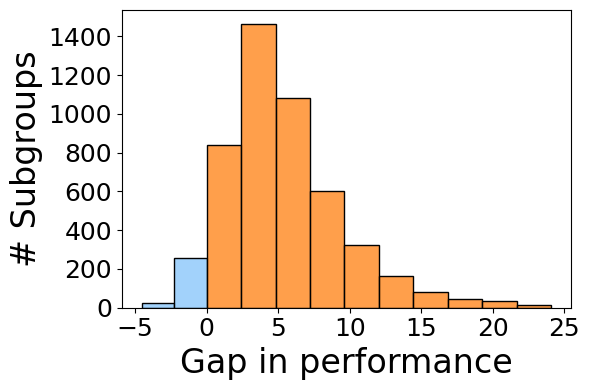

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=2, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/FSC/distribution_gain_w2v2l_xlsr128.pdf")

## Stats

In [107]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),3))

# Percentage of itemsets for which performance are greater for XLSR-128
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 3))

# Percentage of itemsets for which performance are lower for XLSR-128
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]),3))

Equal
3.056
Greater
92.898
Lower
4.046


## Gain > 0

In [108]:
## Retrieve the data cohorts for which XLSR-128 performs better than wav2vec 2.0 large monolingual 
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_w2l-xlsr128"] = (pr["accuracy_w2l-xlsr128"]*100).round(2)
pr["accuracy_w2l-mono"] = (pr["accuracy_w2l-mono"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0  gender=male, loc=none, speakRate=high, tot_silence=high, trim_dur=low   
1                       action=activate, gender=male, speakRate_trim=low   

   d_difference  accuracy_w2l-mono  accuracy_w2l-xlsr128  support  
0         24.06              75.19                 99.25     0.04  
1         23.84              74.83                 98.68     0.04

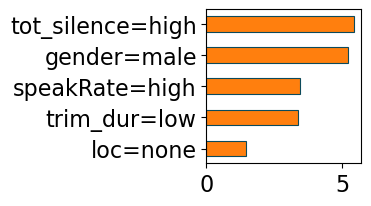

In [109]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    name_fig = "plot_results/FSC/shapley_positive_gain_wlmono_xlsr128.pdf"
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, \
                nameFig=name_fig, saveFig=False)

## Gain < 0 

In [110]:
## Retrieve the data cohorts for which XLSR-128 performs worse than av2vec 2.0 large monolingual
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_w2l-xlsr128"] = (pr["accuracy_w2l-xlsr128"]*100).round(2)
pr["accuracy_w2l-mono"] = (pr["accuracy_w2l-mono"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0  action=increase, age=22-40, gender=male, object=heat, tot_silence=low   
1             action=increase, gender=male, object=heat, tot_silence=low   

   d_difference  accuracy_w2l-mono  accuracy_w2l-xlsr128  support  
0         -4.51              98.50                 93.98     0.04  
1         -4.48              98.51                 94.03     0.04

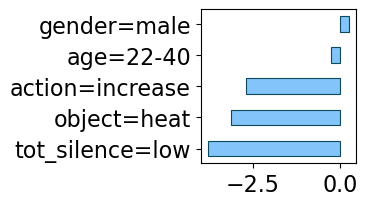

In [111]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    name_fig = "plot_results/FSC/shapley_negative_gain_wlmono_xlsr128.pdf"
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, \
                nameFig=name_fig, saveFig=False, negative=True)

## Gain = 0 

In [112]:
## Retrieve the data cohorts for which XLSR-128 performs equal to wav2vec 2.0 large monolingual
pr = compare_performance[cols][::-1].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_w2l-xlsr128"] = (pr["accuracy_w2l-xlsr128"]*100).round(2)
pr["accuracy_w2l-mono"] = (pr["accuracy_w2l-mono"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]

## Abbreviate itemset names for better visualization
pr_l = pr.head(30).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l = pr_l.sort_values("d_difference").sort_values("accuracy_w2l-xlsr128", ascending=False)
pr_l.head(2)

itemsets  \
218  gender=female, loc=none, n_words=medium, speakRate_trim=high   
217                           action=change lang, trim_dur=medium   

     d_difference  accuracy_w2l-mono  accuracy_w2l-xlsr128  support  
218           0.0              100.0                 100.0     0.03  
217           0.0              100.0                 100.0     0.03

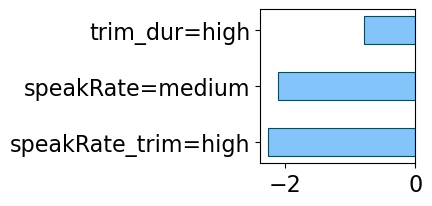

In [113]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [114]:
## Compute the top-K global shapley values related to the gain in performance between wav2vec 2.0 large monolingual and XLSR-128
global_item_divergence_w2lmono_w2lxlsr128 = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2lmono_w2lxlsr128 = {k:v for k,v in global_item_divergence_w2lmono_w2lxlsr128.items() \
                        if k in sorted(global_item_divergence_w2lmono_w2lxlsr128, 
                        key=lambda x: abs(global_item_divergence_w2lmono_w2lxlsr128[x]))[::-1][:K]}

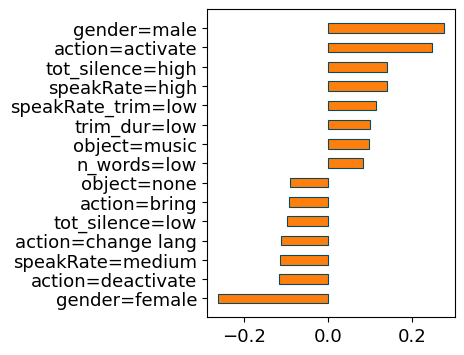

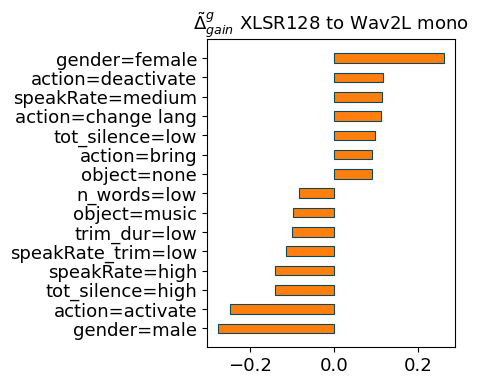

In [115]:
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

## Plot and Save the Image
topK_global_w2lmono_w2lxlsr128_abbr = abbreviateDict(topK_global_w2lmono_w2lxlsr128, abbreviations)
topK_global_w2lmono_w2lxlsr128_abbr = {k:v*100 for k,v in topK_global_w2lmono_w2lxlsr128_abbr.items()}
name_fig = "plot_results/FSC/global_shapley_gain_w2lxlsr128_w2lmono.pdf"
plotShapleyValue(shapley_values=topK_global_w2lmono_w2lxlsr128_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                # title = r"$\tilde{\Delta}^g_{gain}$ Wav2L mono to XLSR128",
                nameFig=name_fig, saveFig=True)

## invert all the values
topK_global_w2lmono_w2lxlsr128_abbr_negative = {k:-v for k,v in topK_global_w2lmono_w2lxlsr128_abbr.items()}
plotShapleyValue(shapley_values=topK_global_w2lmono_w2lxlsr128_abbr_negative, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain}$ XLSR128 to Wav2L mono",
                nameFig=name_fig, saveFig=False)

In [116]:
## Take the K Global Shapley Values for HubB-WavB starting from the top-K of WavL-WavB
topK_global_w2lmono_w2lxlsr128_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2lmono_w2lxlsr128.items() \
                        if k in sorted(topK_global_w2lmono_w2lxlsr53)}, abbreviations)
topK_global_w2lmono_w2lxlsr128_1_abbr = {k: v*100 for k, v in topK_global_w2lmono_w2lxlsr128_1_abbr.items()}

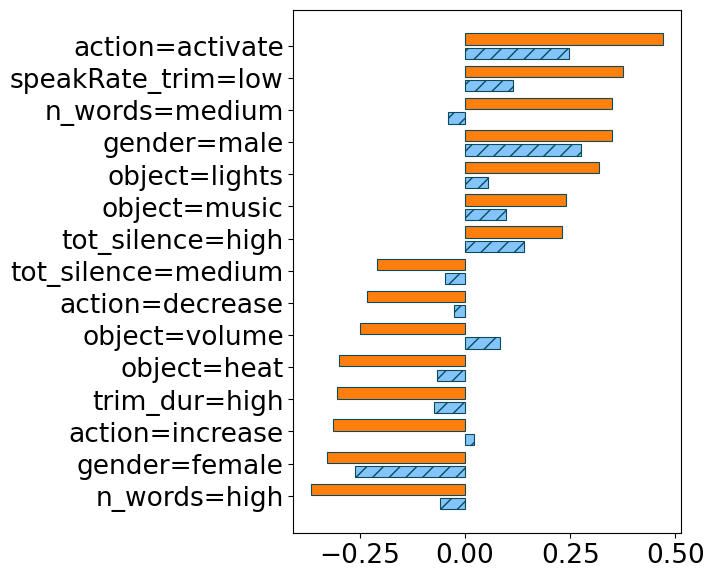

In [117]:
name_fig = f"plot_results/FSC/global_shapley_gain_w2lxlsr53_w2lxlsr128_w2lmono_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/FSC/global_shapley_gain_w2lxlsr53_w2lxlsr128_w2lmono_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2lmono_w2lxlsr53_abbr_negative, 
            shapley_values_2=topK_global_w2lmono_w2lxlsr128_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

In [118]:
## Take the K Global Shapley Values for HubB-WavB starting from the top-K of WavL-WavB
topK_global_w2lmono_w2lxlsr53_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2lmono_w2lxlsr53.items() \
                        if k in sorted(topK_global_w2lmono_w2lxlsr128)}, abbreviations)
topK_global_w2lmono_w2lxlsr53_1_abbr = {k: v*100 for k, v in topK_global_w2lmono_w2lxlsr53_1_abbr.items()}
topK_global_w2lmono_w2lxlsr53_1_abbr_negative = {k:-v for k,v in topK_global_w2lmono_w2lxlsr53_1_abbr.items()}

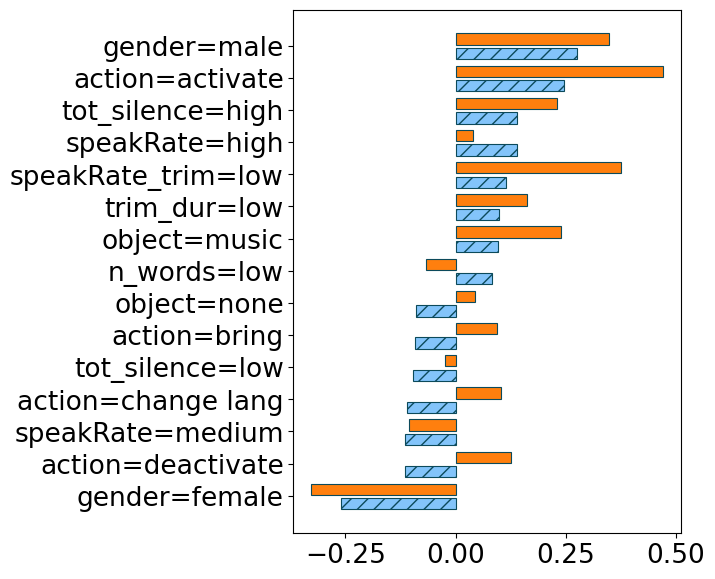

In [119]:
name_fig = f"plot_results/FSC/global_shapley_gain_w2lxlsr128_w2lxlsr53_w2lmono_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/FSC/global_shapley_gain_w2lxlsr128_w2lxlsr53_w2lmono_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2lmono_w2lxlsr128_abbr, 
            shapley_values_2=topK_global_w2lmono_w2lxlsr53_1_abbr_negative,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False, invert=True)

# Divergence difference HuBERT-Base vs HuBERT-Large

In [120]:
## Compute the divergence for HuBERT Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hubl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hubl.set_index("itemsets")

## Compute the divergence for HuBER Base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hubb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hubb.set_index("itemsets")

## Merge the df
merged = hbase.join(hlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [121]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_large"] - merged["accuracy_base"]
merged["difference"] = merged["accuracy_large"] - merged["accuracy_base"]

In [122]:
## Create "Gain Base-Large HuBERT" df and compute divergence
base_large_gain_df = merged[['support', '#errors_large', '#corrects_large', 'accuracy_large',
       'd_accuracy_large', 't_value_large', 'support_count_large', 'length_large'] \
       + [diff, "difference", "accuracy_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [123]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_base', 'accuracy_large', 'support']

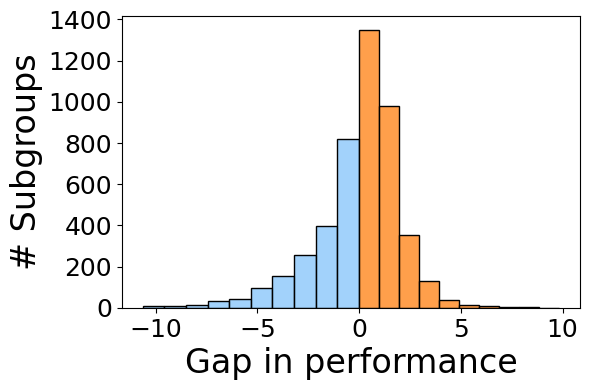

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=10, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/FSC/distribution_gain_hub_base_large.pdf")

## Stats

In [125]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for HuBERT-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
15.703
Greater
51.3323
Lower
32.9646


## Gain > 0

In [126]:
## Retrieve the data cohorts for which HuBERT-Large performs better than HuBERT-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  d_difference  \
0  age=22-40, gender=male, n_words=medium, tot_silence=high          9.84   
1   gender=male, loc=none, n_words=medium, tot_silence=high          8.55   

   accuracy_base  accuracy_large  support  
0          89.34           99.18     0.03  
1          90.60           99.15     0.03

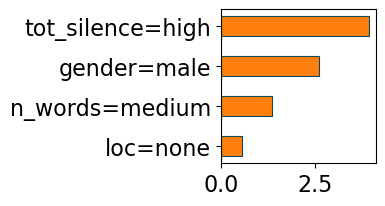

In [127]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[1].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [128]:
## Retrieve the data cohorts for which HuBERT-Large performs worse than HuBERT-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0            speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low   
1  loc=none, speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low   

   d_difference  accuracy_base  accuracy_large  support  
0        -10.64          97.16           86.52     0.04  
1        -10.45          97.76           87.31     0.04

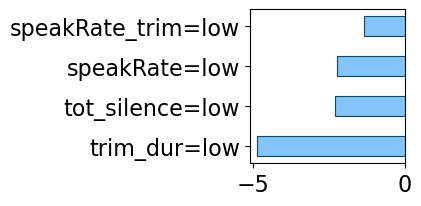

In [129]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [130]:
## Retrieve the data cohorts for which HuBERT-Large performs equal to HuBERT-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support_large"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
2877  action=decrease, object=volume, speakRate=high, trim_dur=low   
2876                                 action=decrease, trim_dur=low   

      d_difference  accuracy_base  accuracy_large   support  support_large  
2877           0.0          95.38           95.38  0.034274           0.03  
2876           0.0          95.42           95.42  0.069075           0.07

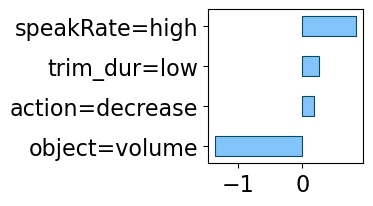

In [131]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [132]:
## Compute the top-K global shapley values related to the gain in performance between HuBERT-Base and HuBERT-Large
global_item_divergence_hb_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_hb_hl = {k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(global_item_divergence_hb_hl, 
                        key=lambda x: abs(global_item_divergence_hb_hl[x]))[::-1][:K]}

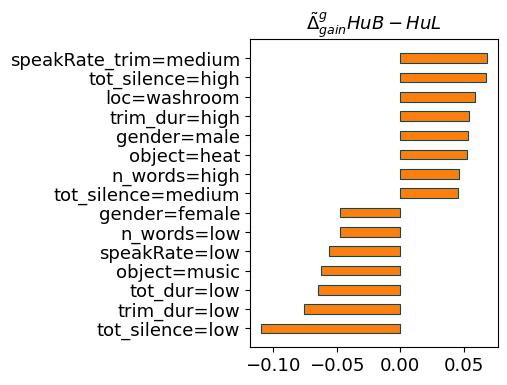

In [133]:
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

## Plot and Save the image 
topK_global_hb_hl_abbr = abbreviateDict(topK_global_hb_hl, abbreviations)
topK_global_hb_hl_abbr = {k:v*100 for k,v in topK_global_hb_hl_abbr.items()}
name_fig = "plot_results/FSC/global_shapley_gain_hb_hl.pdf"
plotShapleyValue(shapley_values=topK_global_hb_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} HuB - HuL$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec2-Large vs Hubert-Large

In [134]:
## Compute the divergence for Hubert-Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hl.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_w2l.set_index("itemsets")

## Merge the df
merged = wlarge.join(hlarge, lsuffix='_w2l', rsuffix='_hl')
merged = merged.rename(columns={'support_hl': 'support'})

In [135]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_hl"] - merged["accuracy_w2l"]
merged["difference"] = merged["accuracy_hl"] - merged["accuracy_w2l"]

In [136]:
## Create "Gain W2Large-HLarge" df and compute divergence
hlarge_w2large_gain_df = merged[['support', '#errors_hl', '#corrects_hl', 'accuracy_hl',
       'd_accuracy_hl', 't_value_hl', 'support_count_hl', 'length_hl'] \
       + [diff, "difference", "accuracy_w2l"]]
hlarge_w2large_gain_df = hlarge_w2large_gain_df.rename(columns={'length_hl':'length'})
hlarge_w2large_gain_df = hlarge_w2large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(hlarge_w2large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [137]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_w2l', 'accuracy_hl', 'support']

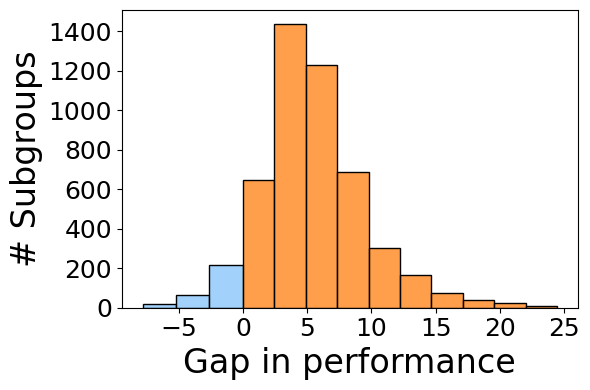

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=3, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/FSC/distribution_gain_w2v2_hub_large.pdf")

## Stats

In [139]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),3))

# Percentage of itemsets for which performance are greater for Hubert-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 3))

# Percentage of itemsets for which performance are lower for Hubert-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]),3))

Equal
2.983
Greater
91.838
Lower
5.178


## Gain > 0

In [140]:
## Retrieve the data cohorts for which Hubert-Large performs better than Wav2Vec2-Large
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hl"] = (pr["accuracy_hl"]*100).round(2)
pr["accuracy_w2l"] = (pr["accuracy_w2l"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  d_difference  \
0               action=increase, gender=male, speakRate=high         24.43   
1  action=increase, gender=male, n_words=low, speakRate=high         23.77   

   accuracy_w2l  accuracy_hl  support  
0         74.81        99.24     0.03  
1         75.41        99.18     0.03

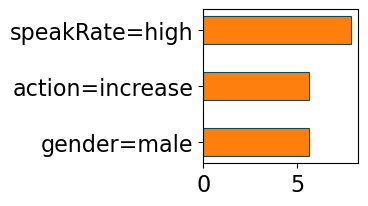

In [141]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [142]:
## Retrieve the data cohorts for which Hubert-Large performs worse than Wav2Vec2-Large
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hl"] = (pr["accuracy_hl"]*100).round(2)
pr["accuracy_w2l"] = (pr["accuracy_w2l"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
0            speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low   
1  loc=none, speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low   

   d_difference  accuracy_w2l  accuracy_hl  support  
0         -7.80         94.33        86.52     0.04  
1         -7.46         94.78        87.31     0.04

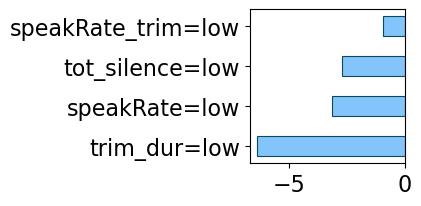

In [143]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [144]:
## Retrieve the data cohorts for which Hubert-Large performs equal to Wav2Vec2-Large
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hl"] = (pr["accuracy_hl"]*100).round(2)
pr["accuracy_w2l"] = (pr["accuracy_w2l"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]

pr = pr.sort_values("d_difference").sort_values("accuracy_hl")
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

itemsets  \
4603  action=increase, age=22-40, gender=male, tot_dur=low, trim_dur=low   
4602                               age=41-65, speakRate=low, tot_dur=low   

      d_difference  accuracy_w2l  accuracy_hl  support  
4603           0.0         92.19        92.19     0.03  
4602           0.0         93.23        93.23     0.04

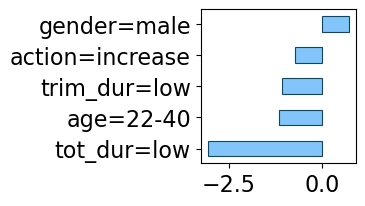

In [145]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [146]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Large and Hubert-Large
global_item_divergence_w2l_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2l_hl = {k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(global_item_divergence_w2l_hl, 
                        key=lambda x: abs(global_item_divergence_w2l_hl[x]))[::-1][:K]}

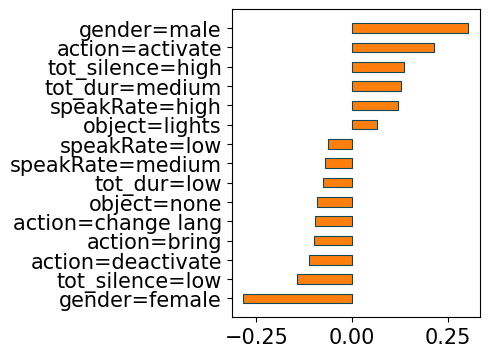

In [147]:
sizeFig = (3.2,4)
labelsize = 15
titlesize = 15

## Plot and Save the Image
topK_global_w2l_hl_abbr = abbreviateDict(topK_global_w2l_hl, abbreviations)
topK_global_w2l_hl_abbr = {k:v*100 for k,v in topK_global_w2l_hl_abbr.items()}
name_fig = "plot_results/FSC/global_shapley_gain_w2l_hl.pdf"
plotShapleyValue(shapley_values=topK_global_w2l_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                #title = r"$\tilde{\Delta}^g_{gain} Wav2L - HubL$",
                nameFig=name_fig, saveFig=True)

In [148]:
## Take the K Global Shapley Values for HubL-WavL starting from the top-K of HubB-WavB
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)
topK_global_w2l_hl_1_abbr = {k:v*100 for k,v in topK_global_w2l_hl_1_abbr.items()}

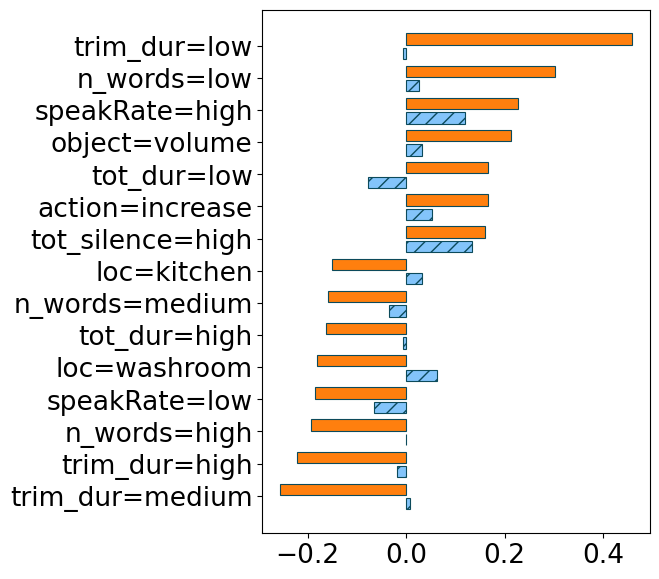

In [149]:
name_fig = f"plot_results/FSC/global_shapley_gain_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/FSC/global_shapley_gain_w2b_hb_w2l_hl_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_hb_abbr, 
            shapley_values_2=topK_global_w2l_hl_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)